<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to address the question above.

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).

Use all the skills you have learned so far to build a predictive model.
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to be able to extrapolate or predict the expected salaries for these listings.

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

## Work

### n.b. start tor in terminal first

In [48]:
# Web crawler
import requests
import bs4
from bs4 import BeautifulSoup
from tqdm import tqdm
from os.path import exists
from dotenv import load_dotenv
import random
import time

# Data Analysis
import numpy as np
import pandas as pd
import re

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
URL = "https://uk.indeed.com/jobs?q=data%20%scientist%20%C2%A345%2C000&l=London"
ip_check = 'http://httpbin.org/ip'

In [3]:
ip = requests.session()

In [4]:
ip.proxies['http'] = 'socks5h://localhost:9050'
ip.proxies['https'] = 'socks5h://localhost:9050'

In [5]:
ip.proxies

{'http': 'socks5h://localhost:9050', 'https': 'socks5h://localhost:9050'}

In [6]:
r = ip.get(ip_check)

In [7]:
print(r.text)

{
  "origin": "51.83.131.42"
}



In [8]:
indeed = requests.session()
indeed.proxies['http'] = 'socks5h://localhost:9050'
indeed.proxies['https'] = 'socks5h://localhost:9050'

r = indeed.get(URL)
soup = BeautifulSoup(r.text,'html.parser')
cards = soup.find_all('table',class_='jobCard_mainContent')

In [9]:
soup

<!DOCTYPE html>

<html dir="ltr" lang="en">
<head>
<meta content="text/html;charset=utf-8" http-equiv="content-type"/>
<script id="polyfill-script-bundle">/* Polyfill service DEVELOPMENT MODE - for live use set NODE_ENV to 'production'
 * Disable minification (remove `.min` from URL path) for more info */

(function(self, undefined) {function ArrayCreate(r){if(1/r==-Infinity&&(r=0),r>Math.pow(2,32)-1)throw new RangeError("Invalid array length");var n=[];return n.length=r,n}function Call(t,l){var n=arguments.length>2?arguments[2]:[];if(!1===IsCallable(t))throw new TypeError(Object.prototype.toString.call(t)+"is not a function.");return t.apply(l,n)}function Get(n,t){return n[t]}function HasOwnProperty(r,t){return Object.prototype.hasOwnProperty.call(r,t)}function HasProperty(n,r){return r in n}function IsArray(r){return"[object Array]"===Object.prototype.toString.call(r)}function IsCallable(n){return"function"==typeof n}function RequireObjectCoercible(e){if(null===e||e===undefined)throw

In [10]:
soup.find("input", id="recaptcha-token") is not None

False

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is in a `span` with `class='salaryText'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 
- Decide which other components could be relevant, for example the region or the summary of the job advert.

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [11]:
def extract_location(result):
    try:
        return result.find('div',class_='companyLocation').get_text()
    except:
        return np.nan

In [12]:
def extract_company(result):
    try:
        return result.find('span',class_='companyName').get_text()
    except:
        return np.nan

In [13]:
def extract_salary(result):
    try:
        try:
            return result.find('div',class_='salary-snippet').get_text()
        except:
            return result.find('div',class_='attribute_snippet').get_text()
    except:
        return np.nan

In [14]:
def extract_title(result):
    try:
        return result.find('h2',class_='jobTitle').get_text()
    except:
        return np.nan

In [15]:
titles = []
for card in cards:
    titles.append(extract_title(card))

In [16]:
locations = []
for card in cards:
    locations.append(extract_location(card))

In [17]:
companies = []
for card in cards:
    companies.append(extract_company(card))

In [18]:
salaries = []
for card in cards:
    salaries.append(extract_salary(card))

In [19]:
titles

['Data Scientist',
 'Data Scientist',
 'Data Scientist',
 'Data Scientist, Personal Banking',
 'newMarketing Data Scientist, Global Client Agency Solutions, gT...',
 'newData Scientist',
 'newData Scientist',
 'newData Scientist',
 'newData Scientist',
 'newData Scientist',
 'Data Scientist',
 'Data Scientist, Risk Data Mining',
 'newData & Applied Scientist',
 'Data Scientist',
 'Data Scientist']

In [20]:
locations

['London',
 'London',
 'London SE1 0AT',
 'London•Remote',
 'London',
 'London',
 'London',
 'London',
 'London EC2M•Remote',
 'London•Remote',
 'London',
 'London',
 'London',
 'London',
 'London']

In [21]:
companies

['IQVIA',
 'TikTok',
 'Fable Data',
 'Monzo',
 'Google',
 'MSD',
 'Bank of England',
 'Data Idols',
 'Ayasdi',
 'Lawrence Harvey',
 'KPMG',
 'TikTok',
 'Microsoft',
 'ARENKO GROUP',
 'Ralph Lauren']

In [22]:
salaries

[nan,
 nan,
 '£50,000 - £60,000 a year',
 nan,
 nan,
 nan,
 '£45,900 - £59,040 a year',
 '£40,000 - £60,000 a year',
 nan,
 '£550 a day',
 nan,
 nan,
 nan,
 nan,
 nan]

In [23]:
pd.DataFrame(zip(locations,companies,titles,salaries), columns = ['location','company','job_title','salary'])

location          company  \
0               London            IQVIA   
1               London           TikTok   
2       London SE1 0AT       Fable Data   
3        London•Remote            Monzo   
4               London           Google   
5               London              MSD   
6               London  Bank of England   
7               London       Data Idols   
8   London EC2M•Remote           Ayasdi   
9        London•Remote  Lawrence Harvey   
10              London             KPMG   
11              London           TikTok   
12              London        Microsoft   
13              London     ARENKO GROUP   
14              London     Ralph Lauren   

                                            job_title  \
0                                      Data Scientist   
1                                      Data Scientist   
2                                      Data Scientist   
3                    Data Scientist, Personal Banking   
4   newMarketing Data Scientist, Global Client Age...   
5                                   newData Scientist   
6                                   newData Scientist   
7                                   newData Scientist   
8                                   newData Scientist   
9                                   newData Scientist   
10                                     Data Scientist   
11                   Data Scientist, Risk Data Mining   
12                        newData & Applied Scientist   
13                                     Data Scientist   
14                                     Data Scientist   

                      salary  
0                        NaN  
1                        NaN  
2   £50,000 - £60,000 a year  
3                        NaN  
4                        NaN  
5                        NaN  
6   £45,900 - £59,040 a year  
7   £40,000 - £60,000 a year  
8                        NaN  
9                 £550 a day  
10                       NaN  
11                       NaN  
12                       NaN  
13                       NaN  
14                       NaN

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

In [24]:
def scrape_indeed(url, session, headers):
    r = session.get(url, headers = headers)
    soup = BeautifulSoup(r.text, 'html.parser')
    return soup

In [25]:
def tor_session():
    session = requests.session()
    session.proxies['http'] = 'socks5h://localhost:9050'
    session.proxies['https'] = 'socks5h://localhost:9050'
    return session

In [26]:
# Dictionary containing user-agent to send to indeed to mask that request comes from a python script
headers = {
    "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36"
}

In [386]:
# Define the maximum number of results to be pulled per job per city.
max_results_per_city_job = 1000

# Dictionary of countries to cities for scraping. Each country has a separate url template for scraping.
countries = {
          'UK': ['London','Manchester','Edinburgh','Glasgow','Bristol','Liverpool',
                    'Birmingham','Leeds','York','Belfast','Newcastle','Margate',
                    'Canterbury','Cardiff','Newport','Swansea']
          , 'US': ['New_York_City','Chicago','Austin','New_Orleans','Los_Angeles']
          , 'FR': ['Paris']
          , 'NL': ['Amsterdam']
          , 'IE': ['Dublin']
          , 'DE': ['Berlin']
         }

# List of job titles to be scraped
job_titles = ['data_scientist', 'data_analyst', 'data_engineer']

In [ ]:
# Set up empty list to append results from scrape to
results = []

# Iterate through each country in the dictionary, pulling the country and its cities.
for country, cities in countries.items():

    # Iterate through each city in the list of cities mapped to the country. 
    # tqdm shows a progress bar
    for city in tqdm(cities):
        print(f'Scraping {city}')
        
        # Replace underscore with %20 which represents a space in the indeed url
        city = city.replace('_','%20')
        
        # Iterate through each job in job_titles
        for job in job_titles:
            print(job)
            
            # Replace underscore with %20 which represents a space in the indeed url
            job = job.replace('_','%20')
            
            # Initialize a tor session to mask my IP address
            session = tor_session()
            
            # Iterate from 0 to max_results_per_city_job in increments of 10 to scrape through multiple pages
            for start in tqdm(range(0, max_results_per_city_job, 10), position=0, leave=True):
                
                # Check which country the current city is in to determine which url to use
                if country == 'UK':
                    url = f'https://uk.indeed.com/jobs?as_and=data%20{job}&as_phr&as_any&as_not&as_ttl&as_cmp&jt=all&st&salary=45000&radius=25&l={city}&fromage=any&limit=10&sort&psf=advsrch&from=advancedsearch&start={start}'
                elif country == 'US':
                    url = f'https://www.indeed.com/jobs?q={job}%20%2445%2C000&l={city}&start={start}'
                elif country == 'FR':
                    url = f'https://fr.indeed.com/jobs?q={job}&l={city}&start={start}'
                elif country == 'NL':
                    url = f'https://nl.indeed.com/jobs?q={job}&l={city}&start={start}'
                elif country == 'IE':
                    url = f'https://ie.indeed.com/jobs?q={job}&l={city}&start={start}'
                elif country == 'DE':
                    url = f'https://de.indeed.com/jobs?q={job}&l={city}&start={start}'
                
                # Get HTML from each web page
                soup = scrape_indeed(url,session,headers=headers)

                # Check if HTML contains recaptcha
                if soup.find("input", id="recaptcha-token") is not None:
                    print('Captcha')
                    
                    # Reset IP address
                    session = tor_session()
                    
                    # Get HTML
                    soup = scrape_indeed(url,session,headers=headers)
                    
                    # Check for Recaptcha again
                    if soup.find("input", id="recaptcha-token") is not None:
                        
                        # Break loop for further investigation
                        print('Captcha recursion')
                        break
                else:
                    # Find all job cards within HTML
                    cards = soup.find_all('table', class_='jobCard_mainContent')
                    
                    # Append job_cards to results list to extract results
                    results.append(cards)
                    
                    # Scrape sleep for random time between 1 and 20 seconds.
                    time.sleep(random.randrange(1, 20))

In [262]:
len(results)

300

In [263]:
results

[[<table cellpadding="0" cellspacing="0" class="jobCard_mainContent" role="presentation"><tbody><tr><td class="resultContent"><div class="heading4 color-text-primary singleLineTitle tapItem-gutter"><h2 class="jobTitle jobTitle-color-purple"><span title="Data Scientist (m/f/x)">Data Scientist (m/f/x)</span></h2></div><div class="heading6 company_location tapItem-gutter"><pre><span class="companyName">Ferratum</span><div class="companyLocation">Berlin</div></pre></div><div class="heading6 error-text tapItem-gutter"></div></td></tr></tbody></table>,
  <table cellpadding="0" cellspacing="0" class="jobCard_mainContent" role="presentation"><tbody><tr><td class="resultContent"><div class="heading4 color-text-primary singleLineTitle tapItem-gutter"><h2 class="jobTitle jobTitle-color-purple jobTitle-newJob"><div class="new topLeft holisticNewBlue desktop"><span class="label">neu</span></div><span title="Applied Data Scientist (d/f/m)">Applied Data Scientist (d/f/m)</span></h2></div><div class="

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [264]:
results_flat = [card for cards in results for card in cards]

In [265]:
len(results_flat)

3975

In [266]:
titles = []
locations = []
companies =[]
salaries = []

In [267]:
for card in results_flat:
    titles.append(extract_title(card))
    locations.append(extract_location(card))
    companies.append(extract_company(card))
    salaries.append(extract_salary(card))

In [306]:
scraped_jobs = pd.DataFrame(zip(titles,locations,companies,salaries),columns=['job_title','location','company','salary'])

In [307]:
scraped_jobs.salary.unique()

array([nan, '5.000 € pro Monat', '70.000 € - 100.000 € pro Jahr',
       '13 € pro Stunde', '1.623 € pro Monat',
       '85.000 € - 95.000 € pro Jahr', '70.000 € pro Jahr',
       '35 € pro Stunde', '26 € pro Stunde',
       '3.000 € - 4.000 € pro Monat', '30 € pro Stunde',
       '45.000 € - 60.000 € pro Jahr', '55.000 € - 65.000 € pro Jahr',
       '38.000 € - 45.000 € pro Jahr', '50.000 € - 80.000 € pro Jahr',
       '12 € - 15 € pro Stunde', '70.000 € - 80.000 € pro Jahr',
       '60.000 € - 75.000 € pro Jahr', '75.000 € - 80.000 € pro Jahr',
       '1.500 € pro Monat', '65.000 € - 80.000 € pro Jahr',
       '40.000 € - 50.000 € pro Jahr', '60.000 € - 85.000 € pro Jahr',
       '60.000 € pro Jahr', '75.000 € - 85.000 € pro Jahr',
       '60.000 € - 70.000 € pro Jahr'], dtype=object)

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

First drop duplicates, reset index and check length of dataframe

In [308]:
## YOUR CODE HERE
scraped_jobs.drop_duplicates(inplace=True)

In [309]:
scraped_jobs.reset_index(drop=True,inplace=True)

In [310]:
scraped_jobs.shape

(1756, 4)

The above shows we have pulled 1756 unique results from the most recent web-scrape.

Next check for null values.

In [311]:
scraped_jobs.isnull().sum()

job_title       0
location        0
company        15
salary       1725
dtype: int64

We can see we have 1725 null values for salary - these will have to be dropped.

I will also drop all salary data which is not 'per year.'

In [312]:
scraped_jobs.dropna(axis=0,how = 'any',inplace=True)

In [313]:
scraped_jobs = scraped_jobs[scraped_jobs['salary'].str.contains('Jahr',case=False)]

In [314]:
scraped_jobs.shape

(20, 4)

This leaves 20 results from the latest scrape.

Finally I will reset the index again.

In [315]:
scraped_jobs.reset_index(drop=True,inplace=True)

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [320]:
## YOUR CODE HERE
def convert_salary(salary):
    # First compile a Regular Expression to find number strings following a '£' sign.
    regex = re.compile(r'(\d{1,3}[.]{1}\d{3})')
        
    amounts = re.findall(regex,salary)
    
    # Use list comprehension to remove all ',' from number strings and then convert to integer.
    salary = [int(re.sub('[.]','',item)) for item in amounts]
    
    # Finally, return the mean of the salary list created above.
    return np.mean(salary)

Use `.apply` to convert all salaries to a number.

In [321]:
scraped_jobs.salary.unique()

array(['70.000 € - 100.000 € pro Jahr', '85.000 € - 95.000 € pro Jahr',
       '70.000 € pro Jahr', '45.000 € - 60.000 € pro Jahr',
       '55.000 € - 65.000 € pro Jahr', '38.000 € - 45.000 € pro Jahr',
       '50.000 € - 80.000 € pro Jahr', '70.000 € - 80.000 € pro Jahr',
       '60.000 € - 75.000 € pro Jahr', '75.000 € - 80.000 € pro Jahr',
       '65.000 € - 80.000 € pro Jahr', '40.000 € - 50.000 € pro Jahr',
       '60.000 € - 85.000 € pro Jahr', '60.000 € pro Jahr',
       '75.000 € - 85.000 € pro Jahr', '60.000 € - 70.000 € pro Jahr'],
      dtype=object)

In [323]:
scraped_jobs.salary = scraped_jobs.salary.apply(convert_salary).copy()

In [324]:
scraped_jobs.salary.unique()

array([85000., 90000., 70000., 52500., 60000., 41500., 65000., 75000.,
       67500., 77500., 72500., 45000., 80000.])

### Save your results as a CSV

Append results to existing csv.

In [259]:
## YOUR CODE HERE
scraped_jobs.to_csv(path_or_buf = 'EU-scraped_jobs.csv',mode = 'a',index=False, header=False)

In [325]:
if exists('EU-scraped_jobs.csv'):
    scraped_jobs.to_csv(path_or_buf = 'EU-scraped_jobs.csv',mode = 'a',index=False, header=False)
else:
    scraped_jobs.to_csv(path_or_buf = 'EU-scraped_jobs.csv',mode = 'w',index=False, header=False)

### Load in the the data of scraped salaries

#### n.b. All below transformations have been saved to final-jobs.csv. Jobs is reloaded from the final-jobs.csv before modelling. 

The reason for this is there are some commands which I ran on the dataframe but have since deleted the lines of code. This has exclusively been during the converting of city names (see above). Some sections of this process would have seen a proliferation of multiple cells running virtually identical lines of code save for changing the index location. The cells above are a sample of the code used.

In [24]:
## YOUR CODE HERE
us_jobs = pd.read_csv('US-jobs.csv')
uk_jobs = pd.read_csv('UK-jobs.csv')
eu_jobs = pd.read_csv('EU-jobs.csv')

In [25]:
us_jobs.head()

job_title  \
0                                     Data Scientist   
1          Data Scientist - Nationwide Opportunities   
2  Data Scientist II - Algorithmic Justice Specia...   
3                                     Data Scientist   
4   Senior Data Scientist - Nationwide Opportunities   

                                            location  \
0                                      Manhattan, NY   
1                           New York, NY+2 locations   
2  New York, NY 10004 (Financial District area)+1...   
3              New York, NY 10012 (SoHo area)•Remote   
4                                       New York, NY   

                     company    salary  
0                NYC Careers   81167.0  
1  Amazon Web Services, Inc.  114700.0  
2                       ACLU  115638.0  
3                   DojoMojo  121845.0  
4  Amazon Web Services, Inc.  116200.0

In [26]:
uk_jobs.head()

job_title    location                    company  \
0                 newData Scientist  London W1W                   Heineken   
1                    Data Scientist      London       Freedom from Torture   
2       newData Scientist (Grade 7)  London SE1  UK Health Security Agency   
3                 newData Scientist      London                 Data Idols   
4  newLead Data Scientist - FinTech      London                 Data Idols   

    salary  
0  55000.0  
1  39120.0  
2  55572.5  
3  50000.0  
4  92500.0

In [27]:
eu_jobs.head()

job_title               location  \
0           newData Scientist Global Tech Co  Dublin, County Dublin   
1                    Data Scientists (AI/ML)  Dublin, County Dublin   
2  Machine Learning, NLP and Computer Vision  Dublin, County Dublin   
3          Data Strategy & Analytics Manager  Dublin, County Dublin   
4                   Data Scientist - Product  Dublin, County Dublin   

                      company    salary  
0                Principle HR  102500.0  
1                 Brightwater   62500.0  
2                 Brightwater   65000.0  
3  Executive Edge Recruitment   91500.0  
4                      Indeed   71000.0

We need to concatenate these dataframes together, but first we need to convert the currencies in uk_jobs and eu_jobs to USD.

In [28]:
from forex_python.converter import CurrencyRates
    
c=CurrencyRates()
   
EUR_fx = c.get_rate('EUR','USD')
GBP_fx = c.get_rate('GBP','USD')

In [29]:
eu_jobs.loc[:,'salary'] = eu_jobs.loc[:,'salary'].apply(lambda x: x*EUR_fx)

In [30]:
uk_jobs.loc[:,'salary'] = uk_jobs.loc[:,'salary'].apply(lambda x: x*GBP_fx)

Now all salaries are denominated in dollars, I can concatenate them.

In [31]:
jobs = pd.concat([us_jobs,uk_jobs,eu_jobs],axis=0)

I'll do one final check for null values

In [32]:
jobs.isnull().sum()

job_title    0
location     0
company      1
salary       0
dtype: int64

In [33]:
jobs.dropna(how = 'any',inplace=True)

There was a null value, which I dropped. 

Finally, I will round all salaries to 2 decimal places.

In [227]:
jobs.loc[:,'salary'] = jobs.loc[:,'salary'].apply(lambda x: round(x,2))

In [228]:
jobs.salary

0        81167.00
1       114700.00
2       115638.00
3       121845.00
4       116200.00
5       112000.00
6       140000.00
7       105900.00
8        62500.00
9        90000.00
10      105900.00
11       82400.00
12       82600.00
13      100550.00
14      130000.00
15       84640.00
16       94688.50
17       64140.00
18      225000.00
19       90803.00
20       94734.00
21       81167.00
22      122300.00
23      128850.00
24       64140.00
25       86400.00
26      140800.00
27       80000.00
28      125000.00
29       81167.00
30       91963.00
31      159081.50
32      130000.00
33      150000.00
34       88313.50
35      129657.00
36      260000.00
37       62500.00
38      110000.00
39      155000.00
40      117500.00
41      152334.50
42       90000.00
43      150000.00
44      195000.00
45       90000.00
46      150941.50
47      155000.00
48      160000.00
49       65000.00
50       62500.00
51      102500.00
52       96000.00
53       65000.00
54       55000.00
55      10

I will now save my data to a final csv: `jobs.csv`.

In [229]:
jobs.to_csv(path_or_buf = 'jobs.csv', mode = 'w', header = True, index = False)

There is still some cleanup required of the other columns too.

#### `job_title`

In [35]:
jobs[jobs.job_title.str.contains('new')]

job_title  \
6                  newStaff Data Scientist - REMOTE USA   
7                                newLead Data Scientist   
33                                    newData Scientist   
35                                    newData Scientist   
36                          newPrincipal Data Scientist   
41                           newQuantitative Researcher   
42               newBusiness Analysts with Data Science   
44                                    newData Architect   
46                               new1628 Data Scientist   
47                         newMachine Learning Engineer   
59      newData Engineer - Marketing Analytics (REMOTE)   
95    newSenior Data Scientist - Consumer Decision S...   
99                        newMachine Learning Scientist   
101                        newMachine Learning Engineer   
111                      newBusiness Analysis Associate   
114   newSenior Business Analyst, Digital HR Service...   
120                     newEntry Level Business Analyst   
124                     newEntry Level Business Analyst   
127                                  newPricing Analyst   
129                                 newBusiness Analyst   
132                                     newData Analyst   
135                 newAzure Data Lake Analytics - Lead   
141                      newSalesforce Business Analyst   
142                        newSoftware Business Analyst   
146                             newSr. Business Analyst   
147                          newSenior Business Analyst   
151     newData Engineer - Marketing Analytics (REMOTE)   
155   newPrincipal Engineer - Software Defined Data ...   
157                             newJunior Data Engineer   
158                                    newData Engineer   
162                              newLead Data Scientist   
165                newStaff Data Scientist - REMOTE USA   
175     newMachine Learning Senior Engineer - Evernorth   
178   newSenior Data Scientist - Consumer Decision S...   
181                       newMachine Learning Scientist   
188                                      newEDI Analyst   
189                               newBusiness Analyst I   
197                                     newData Analyst   
198                                     newData Analyst   
199                         newData Analyst with Python   
200                                 newBusiness Analyst   
202                     newEntry Level Business Analyst   
207                          newSenior Business Analyst   
208         newSr. Business Analyst local to Austin, TX   
211                   newOperations Dashboard Developer   
213   newSenior Salesforce Commerce Cloud Business A...   
214     newData Engineer - Marketing Analytics (REMOTE)   
221                         newData Operations Engineer   
232        newSenior Systems and Data Analyst (Virtual)   
237                            newSenior Data Scientist   
245   newBarksdale - UIpath RPA Developer / Business...   
255                          newSr. Application Analyst   
264                     newEntry Level Business Analyst   
266                         newAir Quality Data Analyst   
268                                 newBusiness Analyst   
269                           newAgile Business Analyst   
270                               newOperations Analyst   
275          newSenior HRIS + People Operations Analyst   
278   newBoard Certified Behavior Analyst (BCBA) Cli...   
280     newData Engineer - Marketing Analytics (REMOTE)   
286                                newBig Data Engineer   
0                                     newData Scientist   
2                           newData Scientist (Grade 7)   
3                                     newData Scientist   
4                      newLead Data Scientist - FinTech   
5                                newLead Data Scientist   
6                                     newData Scientist   
9                                 

In [36]:
jobs.loc[:,'job_title']=jobs.loc[:,'job_title'].apply(lambda x: x.replace('new',''))

In [37]:
jobs[jobs.job_title.str.contains('new')]

Empty DataFrame
Columns: [job_title, location, company, salary]
Index: []

In [38]:
pd.DataFrame(jobs.job_title.unique())

0
0                                        Data Scientist
1             Data Scientist - Nationwide Opportunities
2     Data Scientist II - Algorithmic Justice Specia...
3      Senior Data Scientist - Nationwide Opportunities
4                                        DATA SCIENTIST
5                     Staff Data Scientist - REMOTE USA
6                                   Lead Data Scientist
7       Senior Data Analyst/Data Scientist/Data Analyst
8                                    Sr. Data Scientist
9                        Product Analyst/Data Scientist
10           Associate Data & Machine Learning Engineer
11                                Senior Data Scientist
12    Environmental Health Data Scientist, Bureau of...
13    Chief Data Scientist – Racial Profiling and Bi...
14    City Research Scientist I / Data Analyst, Bure...
15    Associate Partner, Enterprise Strategy (Data, ...
16    Senior Data Analyst - Visualization and Reporting
17    City Research Scientist III / Director of Data...
18    Senior Data Analyst, Bureau of Tuberculosis Co...
19                               Sr. Data & ML Engineer
20              Machine Learning Visualization Engineer
21    City Research Scientist I / Policy and Data An...
22                  Senior Data Scientist- Boost Mobile
23    Data Engineer - Data Science Platforms & Infra...
24         Senior Data Analyst, Mayor's Office of M/WBE
25                                        Data Engineer
26                              Senior Research Analyst
27                         Data Scientist- Test & Trace
28                       Data Scientist – Deep learning
29                             Principal Data Scientist
30    Immediate Hiring in Java and Data Science on W...
31                 Researcher (Research Data Scientist)
32                            Full Stack Data Scientist
33                              Quantitative Researcher
34                  Business Analysts with Data Science
35                                       Data Architect
36                        Data Analyst / Data Scientist
37                                  1628 Data Scientist
38                            Machine Learning Engineer
39                  Senior Analyst, Learning Management
40                         Senior Analyst, Service Desk
41           Product Analyst-Enterprise Data Management
42                           Technical Business Analyst
43                           Technology Project Analyst
44                      Analyst, Procurement Operations
45                                     Business Analyst
46                           Senior IT Business Analyst
47                                     Data Engineer II
48         Data Engineer - Marketing Analytics (REMOTE)
49    Staff Software Engineer : Data Management Serv...
50                                   Lead Data Engineer
51                  Data Analyst/ Engineer/ Entry Level
52            Cybersecurity Vulnerability Data Engineer
53                                       Data Engineer!
54                          Fan Data Solutions Engineer
55                                Data Engineer Level I
56         Sr Data Engineer (Data Pipeline & Analytics)
57                     Data Engineer/Architect - Remote
58    Software Engineer - Data Engineering / Python ...
59                                     Data QC Engineer
60     Senior Systems Engineer | Data Center Operations
61    Data Scientist - Operations Research (CPLEX/Gu...
62    Data Science Manager (Remote - Home Based Worker)
63                           Health Care Data Scientist
64                                    Applied Scientist
65                 Data Analyst 2 – Strategic Analytics
66     Statistician / Researcher - Statistics & Methods
67    Senior Data Scientist - NLP, Computer Vision, ...
68    Data Analytics Engineer /BI Engineer, Senior, ...
69    Junior Sales Engineer--AI Cybersecurity--Chica...
70                   Senior Statistical Programmer, SAS
71    Senior Manager D

In [39]:
jobs.loc[:,'job_title']=jobs.loc[:,'job_title'].apply(lambda x: x.replace(' - Nationwide Opportunities',''))

In [54]:
jobs.loc[:,'job_title']=jobs.loc[:,'job_title'].apply(lambda x: x.replace(' (Remote)',''))

In [43]:
jobs.loc[:,'job_title']=jobs.loc[:,'job_title'].apply(lambda x: x.replace(' - REMOTE USA',''))

In [49]:
jobs[jobs.job_title.str.contains('Immediate')]

job_title  \
37  Immediate Hiring in Java and Data Science on W2 roles   

                           location                      company   salary  
37  New York, NY•Temporarily Remote  TechIntelli Solutions, Inc.  62500.0

In [52]:
jobs.loc[:,'job_title']=jobs.loc[:,'job_title'].apply(lambda x: 'Data Scientist' if 'Immediate' in x else x)

In [116]:
jobs.loc[:,'job_title']=jobs.loc[:,'job_title'].apply(lambda x: re.sub(r'[.]{3}$','',x))

In [97]:
jobs.loc[:,'job_title']=jobs.loc[:,'job_title'].apply(lambda x: x.replace('--Chicago OR ',''))

In [118]:
pd.DataFrame(jobs.job_title.unique())

0
0                                                   Data Scientist
1               Data Scientist II - Algorithmic Justice Specialist
2                                            Senior Data Scientist
3                                                   DATA SCIENTIST
4                                             Staff Data Scientist
5                                              Lead Data Scientist
6                  Senior Data Analyst/Data Scientist/Data Analyst
7                                               Sr. Data Scientist
8                                   Product Analyst/Data Scientist
9                       Associate Data & Machine Learning Engineer
10                             Environmental Health Data Scientist
11                                           Chief Data Scientist 
12                        City Research Scientist I / Data Analyst
13                         Associate Partner, Enterprise Strategy 
14               Senior Data Analyst - Visualization and Reporting
15                  City Research Scientist III / Director of Data
16             Senior Data Analyst, Bureau of Tuberculosis Control
17                                          Sr. Data & ML Engineer
18                         Machine Learning Visualization Engineer
19             City Research Scientist I / Policy and Data Analyst
20                             Senior Data Scientist- Boost Mobile
21         Data Engineer - Data Science Platforms & Infrastructure
22                    Senior Data Analyst, Mayor's Office of M/WBE
23                                                   Data Engineer
24                                         Senior Research Analyst
25                                    Data Scientist- Test & Trace
26                                  Data Scientist – Deep learning
27                                        Principal Data Scientist
28                                                     Researcher 
29                                       Full Stack Data Scientist
30                                         Quantitative Researcher
31                             Business Analysts with Data Science
32                                                  Data Architect
33                                   Data Analyst / Data Scientist
34                                             1628 Data Scientist
35                                       Machine Learning Engineer
36                             Senior Analyst, Learning Management
37                                    Senior Analyst, Service Desk
38                      Product Analyst-Enterprise Data Management
39                                      Technical Business Analyst
40                                      Technology Project Analyst
41                                 Analyst, Procurement Operations
42                                                Business Analyst
43                                      Senior IT Business Analyst
44                                                Data Engineer II
45                             Data Engineer - Marketing Analytics
46                                         Staff Software Engineer
47                                              Lead Data Engineer
48                             Data Analyst/ Engineer/ Entry Level
49                       Cybersecurity Vulnerability Data Engineer
50                                                  Data Engineer!
51                                     Fan Data Solutions Engineer
52                                           Data Engineer Level I
53                                               Sr Data Engineer 
54                                        Data Engineer/Architect 
55        Software Engineer - Data Engineering / Python / REST API
56                                                Data QC Engineer
57                Senior Systems Engineer | Data Center Operations
58                           Data Scientist - Operations Research 
59                                           

In [132]:
jobs.drop(168,axis=0,inplace=True)

In [136]:
jobs.reset_index(drop=True, inplace=True)

#### `location`

In [137]:
jobs.location.unique()

array(['Manhattan, NY', 'New York, NY+2 locations',
       'New York, NY 10004 (Financial District area)+1 location•Remote',
       'New York, NY 10012 (SoHo area)•Remote', 'New York, NY',
       'New York, NY 10018 (Garment District area)•Remote',
       'New York, NY 10041 (Financial District area)+1 location',
       'Long Island City, NY 11101',
       'New York, NY 10041 (Financial District area)',
       'New York, NY 10036 (Garment District area)',
       'New York, NY 10014 (West Village area)',
       'New York, NY 10118 (Chelsea area)+1 location',
       'New York, NY 10310 (West Brighton area)',
       'Queens, NY 11101+1 location', 'New York, NY 10001 (Chelsea area)',
       'Long Island City, NY 11101•Remote', 'Queens, NY 11101',
       'Queens, NY 11101+2 locations',
       'New York, NY 10004 (Financial District area)+3 locations',
       'Roseland, NJ 07068',
       'New York, NY 10004 (Financial District area)+1 location',
       'New York, NY•Remote', 'Flushing, NY 11

#### Convert US cities

In [146]:
jobs.loc[:, 'location'] = jobs.loc[:, 'location'].apply(
    lambda x: 'new_york' if ' NY' in x or 'NJ' in x else 'chicago' if 'IL' in x else 'austin' if 'TX' in x else 'new_orleans' if ' LA' in x else 'los_angeles' if ' CA' in x else x )

In [168]:
converted_city = ['new_york','chicago','los_angeles','new_orleans','austin','london','manchester','edinburgh','glasgow','bristol']

#### Convert London-based locations to London

In [152]:
jobs.iloc[285:699,1] = jobs.iloc[285:699,1].apply(lambda x: 'london')

#### Convert Manchester

In [153]:
jobs.iloc[699:766,1] = jobs.iloc[699:766,1].apply(lambda x: 'manchester')

#### Convert Edinburgh

In [155]:
jobs.iloc[766:781,1] = jobs.iloc[766:781,1].apply(lambda x: 'edinburgh')

#### Convert Glasgow

In [164]:
jobs.iloc[781:821,1] = jobs.iloc[781:821,1].apply(lambda x: 'glasgow')

#### Convert Bristol

In [165]:
jobs.iloc[821:857,1] = jobs.iloc[821:857,1].apply(lambda x: 'bristol')

#### Convert Liverpool

In [170]:
jobs.iloc[857:932,1] = jobs.iloc[857:932,1].apply(lambda x: 'liverpool')

converted_city.append('liverpool')

#### Convert Birmingham

In [172]:
jobs.iloc[932:1042,1] = jobs.iloc[932:1042,1].apply(lambda x: 'birmingham')

converted_city.append('birmingham')

#### Convert Leeds

In [174]:
jobs.iloc[1042:1145,1] = jobs.iloc[1042:1145,1].apply(lambda x: 'leeds')

converted_city.append('leeds')

In [180]:
jobs.iloc[1162:1215,1] = jobs.iloc[1162:1215,1].apply(lambda x: 'leeds')

#### Convert Aberdeen

In [176]:
jobs.iloc[1145:1147,1] = jobs.iloc[1145:1147,1].apply(lambda x: 'aberdeen')

converted_city.append('aberdeen')

#### Convert Belfast

In [178]:
jobs.iloc[1147:1162,1] = jobs.iloc[1147:1162,1].apply(lambda x: 'belfast')

converted_city.append('belfast')

#### Convert Newcastle

In [182]:
jobs.iloc[1215:1259,1] = jobs.iloc[1215:1259,1].apply(lambda x: 'newcastle')

converted_city.append('newcastle')

#### Convert Kent

In [185]:
jobs.iloc[1259:1283,1]= jobs.iloc[1259:1283,1].apply(lambda x: 'kent')

converted_city.append('kent')

#### Convert Cardiff, Bristol

Cardiff and Bristol are very close together, so the scrape for Cardiff has picked up several jobs which are actually listed in Bristol

In [187]:
jobs.iloc[1283:1289,1]= jobs.iloc[1283:1289,1].apply(lambda x: 'cardiff')

converted_city.append('cardiff')

In [210]:
jobs.iloc[1317,1]= 'cardiff'

In [196]:
jobs.iloc[[1300,1303,1306],1]= jobs.iloc[[1300,1303,1306],1].apply(lambda x: 'cardiff')

In [207]:
jobs.iloc[1314:1316,1]= jobs.iloc[1314:1316,1].apply(lambda x: 'cardiff')

In [189]:
jobs.iloc[1289:1292,1]= jobs.iloc[1289:1292,1].apply(lambda x: 'bristol')

In [194]:
jobs.iloc[1293:1300,1]= jobs.iloc[1293:1300,1].apply(lambda x: 'bristol')

In [212]:
jobs.iloc[1318:1325,1]= jobs.iloc[1318:1325,1].apply(lambda x: 'bristol')

In [209]:
jobs.iloc[1316,1]= 'bristol'

#### Convert Swansea

In [216]:
jobs.iloc[1325:1335,1]= jobs.iloc[1325:1335,1].apply(lambda x: 'swansea')

converted_city.append('swansea')

#### Convert Dublin

In [218]:
jobs.iloc[1335:1421,1]= jobs.iloc[1335:1421,1].apply(lambda x: 'dublin')

converted_city.append('dublin')

#### Convert Paris

In [220]:
jobs.iloc[1421:1629,1]= jobs.iloc[1421:1629,1].apply(lambda x: 'paris')

converted_city.append('paris')

#### Convert Amsterdam

In [222]:
jobs.iloc[1629:1985,1]= jobs.iloc[1629:1985,1].apply(lambda x: 'amsterdam')

converted_city.append('amsterdam')

#### Convert Berlin

In [224]:
jobs.iloc[1985:,1]= jobs.iloc[1985:,1].apply(lambda x: 'berlin')

converted_city.append('berlin')

In [226]:
jobs.location.unique()

array(['new_york', 'chicago', 'austin', 'new_orleans', 'los_angeles',
       'london', 'manchester', 'edinburgh', 'glasgow', 'bristol',
       'liverpool', 'birmingham', 'leeds', 'aberdeen', 'belfast',
       'newcastle', 'kent', 'cardiff', 'swansea', 'dublin', 'paris',
       'amsterdam', 'berlin'], dtype=object)

Now all values in the location column have been grouped in relation to their nearest city.

### Investigate Target Variable: Salary

In [416]:
# Import relevant data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
sns.set_theme(style="whitegrid", palette="muted")

First, I think it will be useful to get the key descriptive statistics for salary.

In [247]:
jobs.describe()

salary
count    2005.000000
mean    70136.873850
std     30868.570586
min     17150.940000
25%     48937.110000
50%     63046.500000
75%     82400.000000
max    275112.000000

In [253]:
max_std_away_from_mean = (275112 - 70136.87385)/30868.570586

In [254]:
max_std_away_from_mean

6.640253249788104

We can use `.describe()` on jobs just to pull salary data as this is our only non-categorical variable in the data set.

The mean salary is greater than the median salary, implying a positively-skewed distribution. We can use a histogram to confirm this.

Also, there is at least one outlier as the maximum salary: $275112.00 is {{round(max_std_away_from_mean,4)}} standard deviations away from the mean. I will show this using a boxplot.

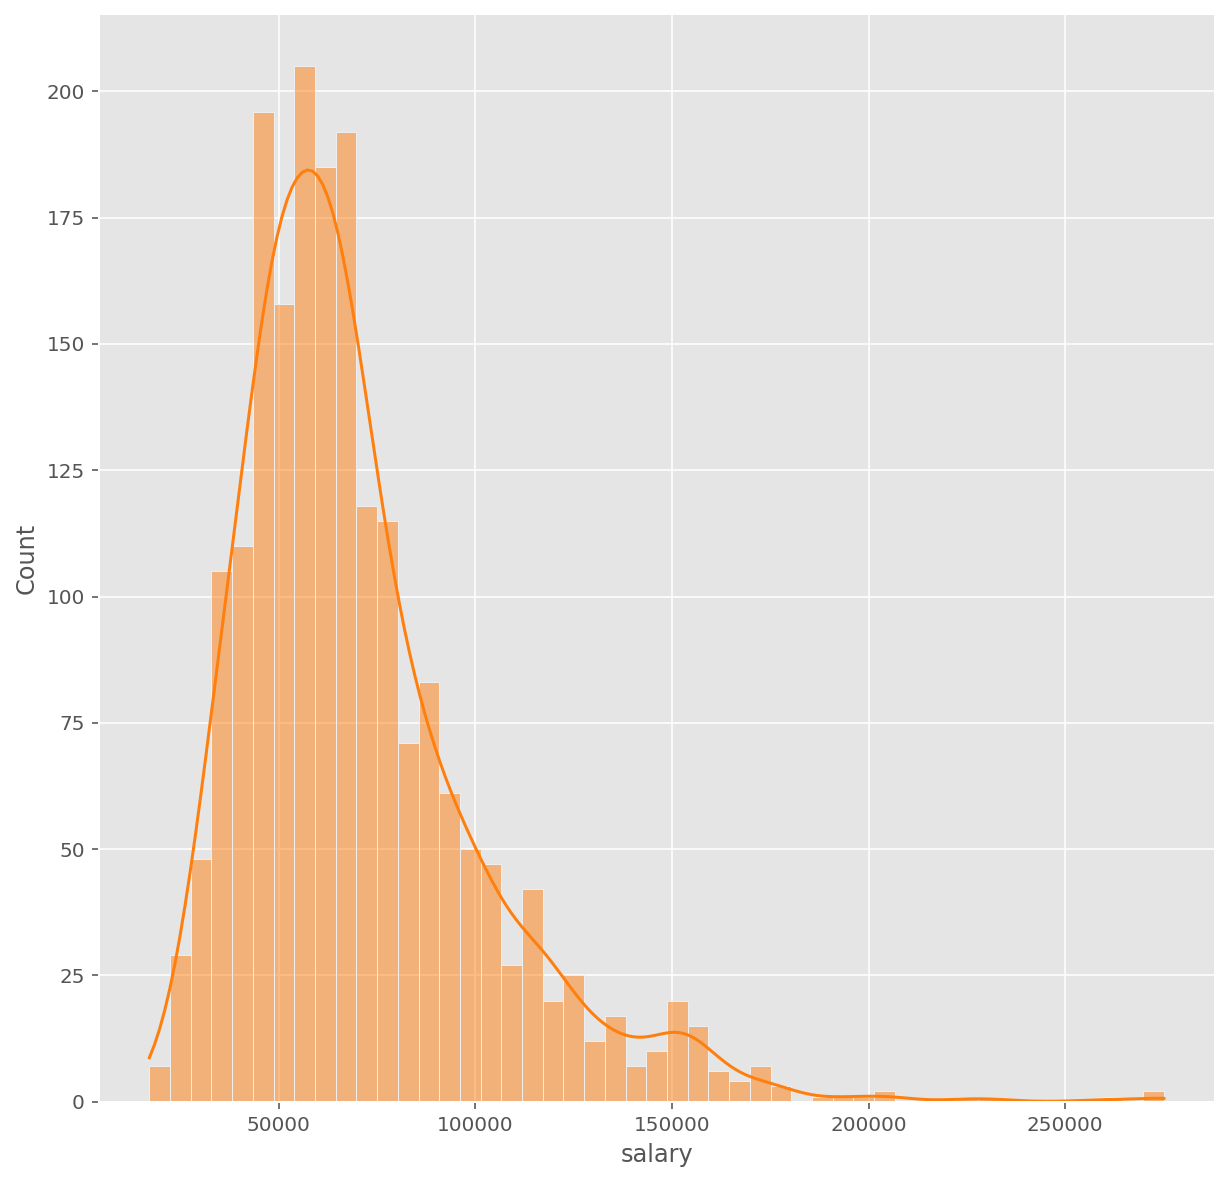

In [251]:
figure = plt.figure(figsize=(10,10))
sns.histplot(jobs.salary, stat='count',color='tab:orange',kde=True)
plt.show();

The above histogram confirms that the distribution has a positive-skew. We can also see that there are several records above $200,000 p.a. - these may be outliers. As stated above I will continue with my plan to use a  boxplot to identify outliers.

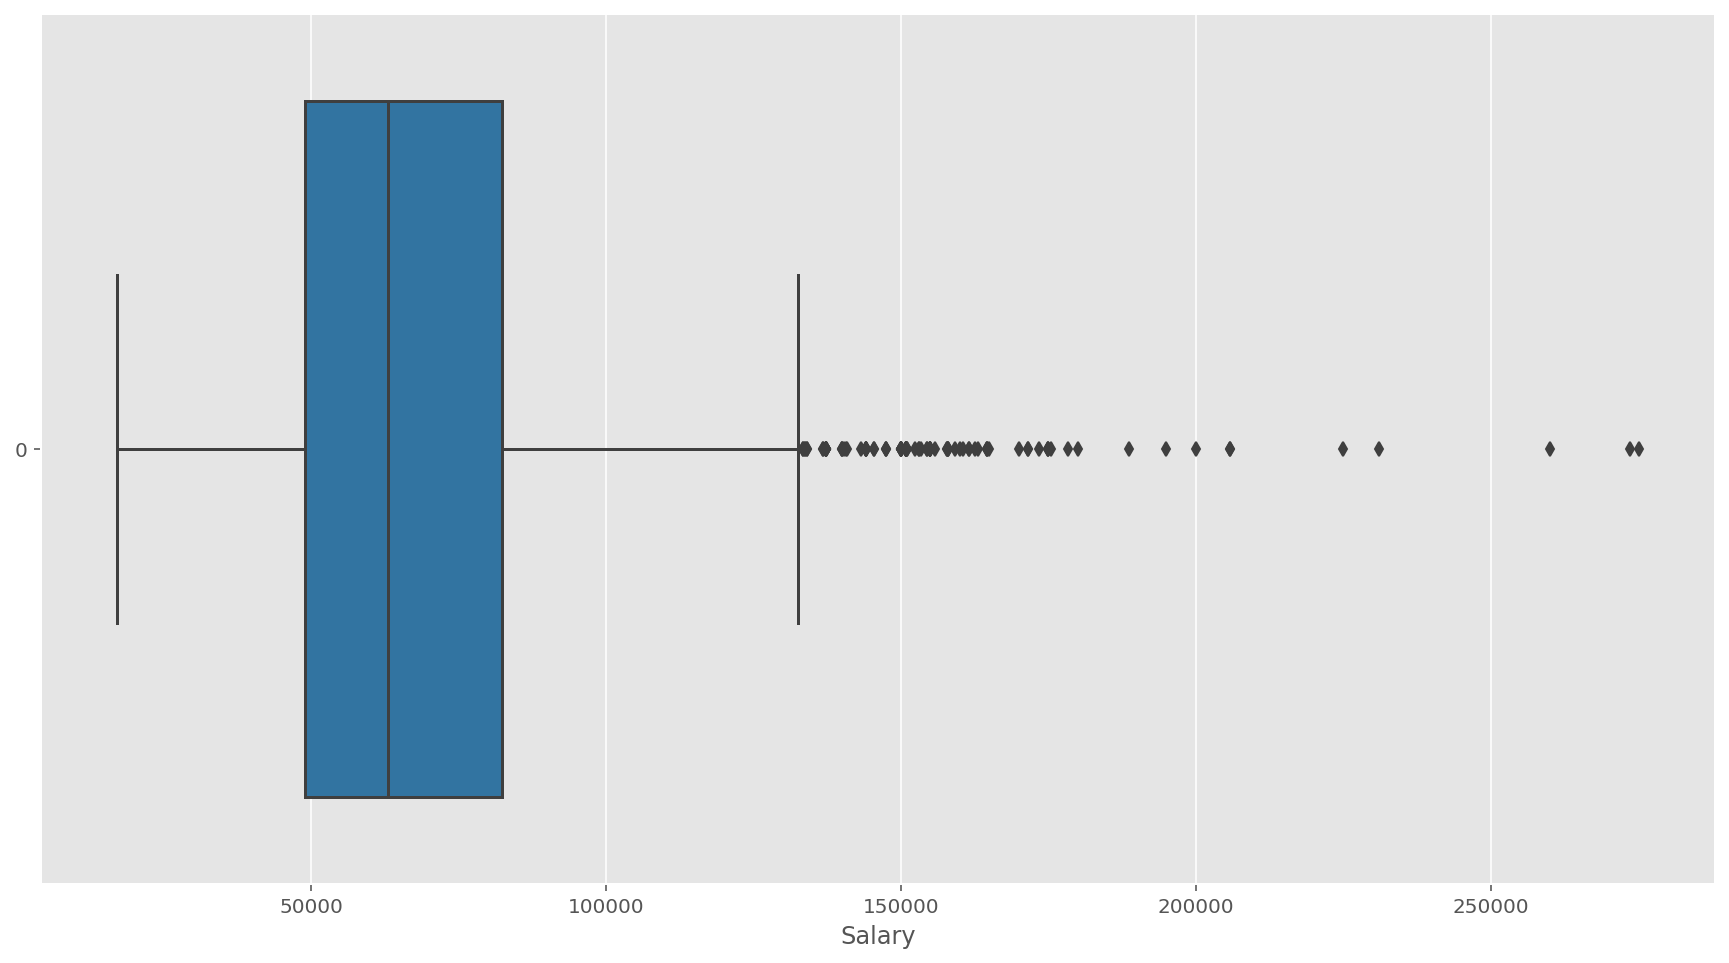

In [264]:
fig = plt.figure(figsize=(15,8))
sns.boxplot(data=jobs.salary,orient='h',whis=1.5, color='tab:blue')
plt.xlabel('Salary')
plt.show();

The above boxplot shows that there are many outliers. However, this boxplot shows the absolute value of these outliers. I am curious to know the z_score for these outliers so I can assess how far from the mean they are.

In [256]:
def var_standardize(var):
    var_stand = (var-var.mean())/var.std()
    return var_stand

In [266]:
jobs['z_salary'] = var_standardize(jobs.salary)

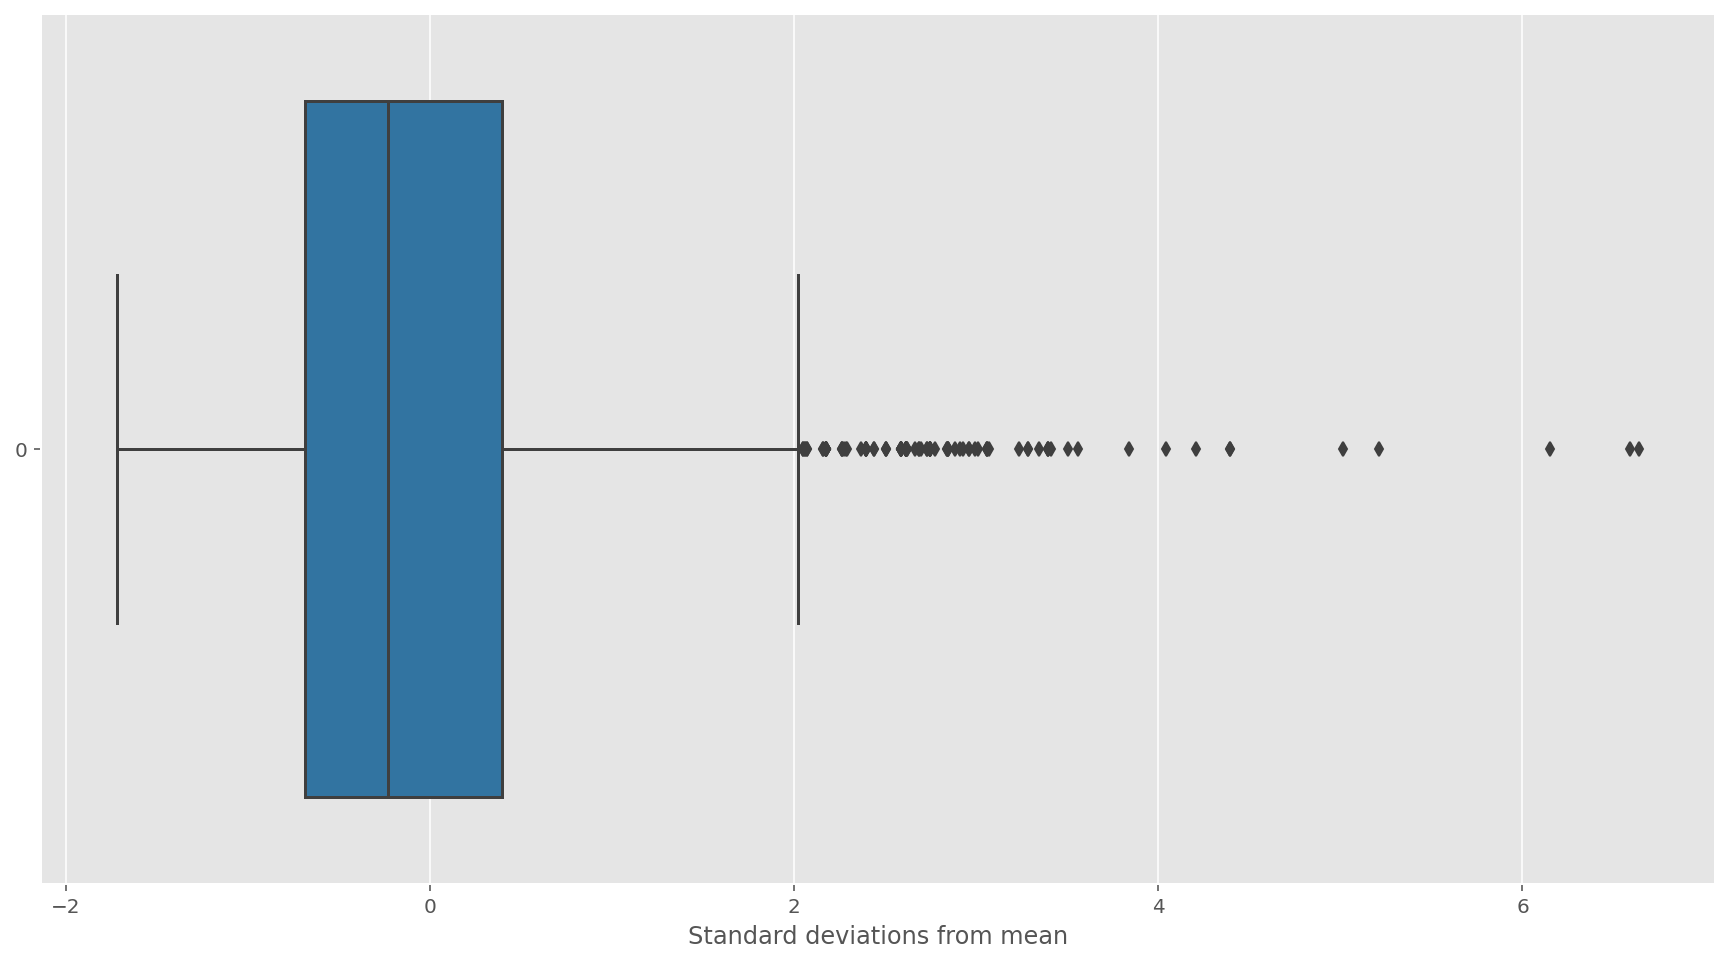

In [267]:
fig = plt.figure(figsize=(15,8))
sns.boxplot(data=jobs.z_salary,orient='h',whis=1.5, color='tab:blue')
plt.xlabel('Standard deviations from mean')
plt.show();

It is not unsurprising for there to be significantly high salaries in the data science field. Despite this, I will investigate the top 10 rows for `z_salary` which is the z_score for each salary. This will allow me to check these salaries are legitimate.

In [278]:
jobs.sort_values(by='z_salary',ascending=False).head(10)

job_title     location  \
175  Principal Data Scientist - Match Recommendations       austin   
36                           Principal Data Scientist     new_york   
228                           Data Scientist/Marketer  los_angeles   
18            Associate Partner, Enterprise Strategy      new_york   
490                                       Head of NLP       london   
411                             Director Data Science       london   
279                                 Sr. Data Engineer  los_angeles   
44                                     Data Architect     new_york   
430                          Principal Data Scientist       london   
233       Principal Data Scientist - People Insights   los_angeles   

                       company     salary salary_band  z_salary  
175                     Indeed  273500.00        HIGH  6.663923  
36            Trace Technosoft  260000.00        HIGH  6.221746  
228             Pinnacle Group  231100.00        HIGH  5.275160  
18                         IBM  225000.00        HIGH  5.075361  
490  MBN Recruitment Solutions  205811.24        HIGH  4.446855  
411  MBN Recruitment Solutions  205811.24        HIGH  4.446855  
279                     Kinect  200000.00        HIGH  4.256515  
44            Info Origin Inc.  195000.00        HIGH  4.092745  
430                      Red10  188660.30        HIGH  3.885096  
233                  Genentech  180000.00        HIGH  3.601438

The highest earning salary for BizTek recruitment is a projected salary based on on-target-earnings.

The base salary is €80,000 p.a. For this reason, I will convert the salary for this row to €80,000 * EUR_FX rate and convert the z_score.

In [275]:
jobs.loc[1949,'salary'] = round(80000 * EUR_fx,2)

In [277]:
jobs.z_salary = var_standardize(jobs.salary)

The other salaries look acceptable after checking the job_cards for each. I don't think dropping them is appropriate as this is a field where very high salaries are possible.

I think it would be appropriate, however to group these salaries into more bands than just `LOW` and `HIGH`.

Finally, I will check the top 5 salaries for each city.

In [408]:
top_5 = jobs.groupby(by='location', as_index=False).apply(lambda x: x.nlargest(5,'salary'))

In [409]:
top_5.sort_values(by='salary',ascending = False)

job_title  \
2  175              Principal Data Scientist - Match Recommendations   
19 36                                       Principal Data Scientist   
16 228                                       Data Scientist/Marketer   
19 18                        Associate Partner, Enterprise Strategy    
15 490                                                   Head of NLP   
   411                                         Director Data Science   
16 279                                             Sr. Data Engineer   
19 44                                                 Data Architect   
15 430                                      Principal Data Scientist   
16 233                   Principal Data Scientist - People Insights    
10 773                        Data Science Platform Engineering Lead   
19 70                                                  Data Engineer   
2  221                 Staff Software Engineer - Data Infrastructure   
16 235                                         Senior Data Scientist   
15 413                      Head of Data Science - Advisory - London   
16 280                                  Principal, Big Data Engineer   
15 474                                 SVP Analytics & Data Science    
2  219                                      Data Operations Engineer   
   172                                 Solution Architect - Big Data   
8  93                       Data Science and Analytics Lab Engineer    
   117                           Sr. Manager - Business Intelligence   
2  166                                            Sr. Data Scientist   
9  1406                                           FPGA/ASIC Engineer   
19 48                                                 Data Scientist   
8  153                                       Staff Software Engineer   
   86    Senior Data Scientist - NLP, Computer Vision, Deep Learning   
   90              Senior Manager Data Analytics - Marketing and Web   
1  1900                                       Software Data Engineer   
21 1477               Director Data Analytics and Business Insights    
17 704                            Senior Deep Learning / AI Engineer   
   703                  Head of Data Science – Manchester - £70-120K   
9  1403           Senior Data Engineer - Dublin, Ireland - Permanent   
   1373                                    Marketing Science Analyst   
1  1926                                             ICT Professional   
10 771                                                    Consultant   
1  1963                                          Lead Data Scientist   
21 1580              Data engineer pour un grand groupe d'assurance    
6  1288                                         Data Science Manager   
10 770     Professor in Artificial Intelligence and Machine Learning   
9  1325                                Data Scientist Global Tech Co   
13 1107                                     Power BI Developer - FTC   
1  1949                                   Senior Software Developer    
   1882                                                Data Engineer   
14 866                                           Associate Director    
6  1291                             Senior Machine Learning Engineer   
9  1330                                        Senior Data Scientist   
4  1975                                    Machine Learning Engineer   
21 1614                                      [Full ] Principal Front   
4  1968                            Senior Product Manager - Security   
21 1558                                          LEAD DATA ENGINEER    
13 1195                      Business Intelligence and SQL Developer   
21 1457                                        Head of Data Science    
10 775                     Senior Data Scientist - Machine Learning    
17 700                                           Lead Data Scientist   
5  941                                         Senior Data Scientist   
4  1967                    

From the above dataframe, we can see that the cities with the highest earning potential are:
- Austin
- New York
- Los Angeles
- London
- Edinburgh

I will now visualise the distribution of this:

/Users/PatrickPagni/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


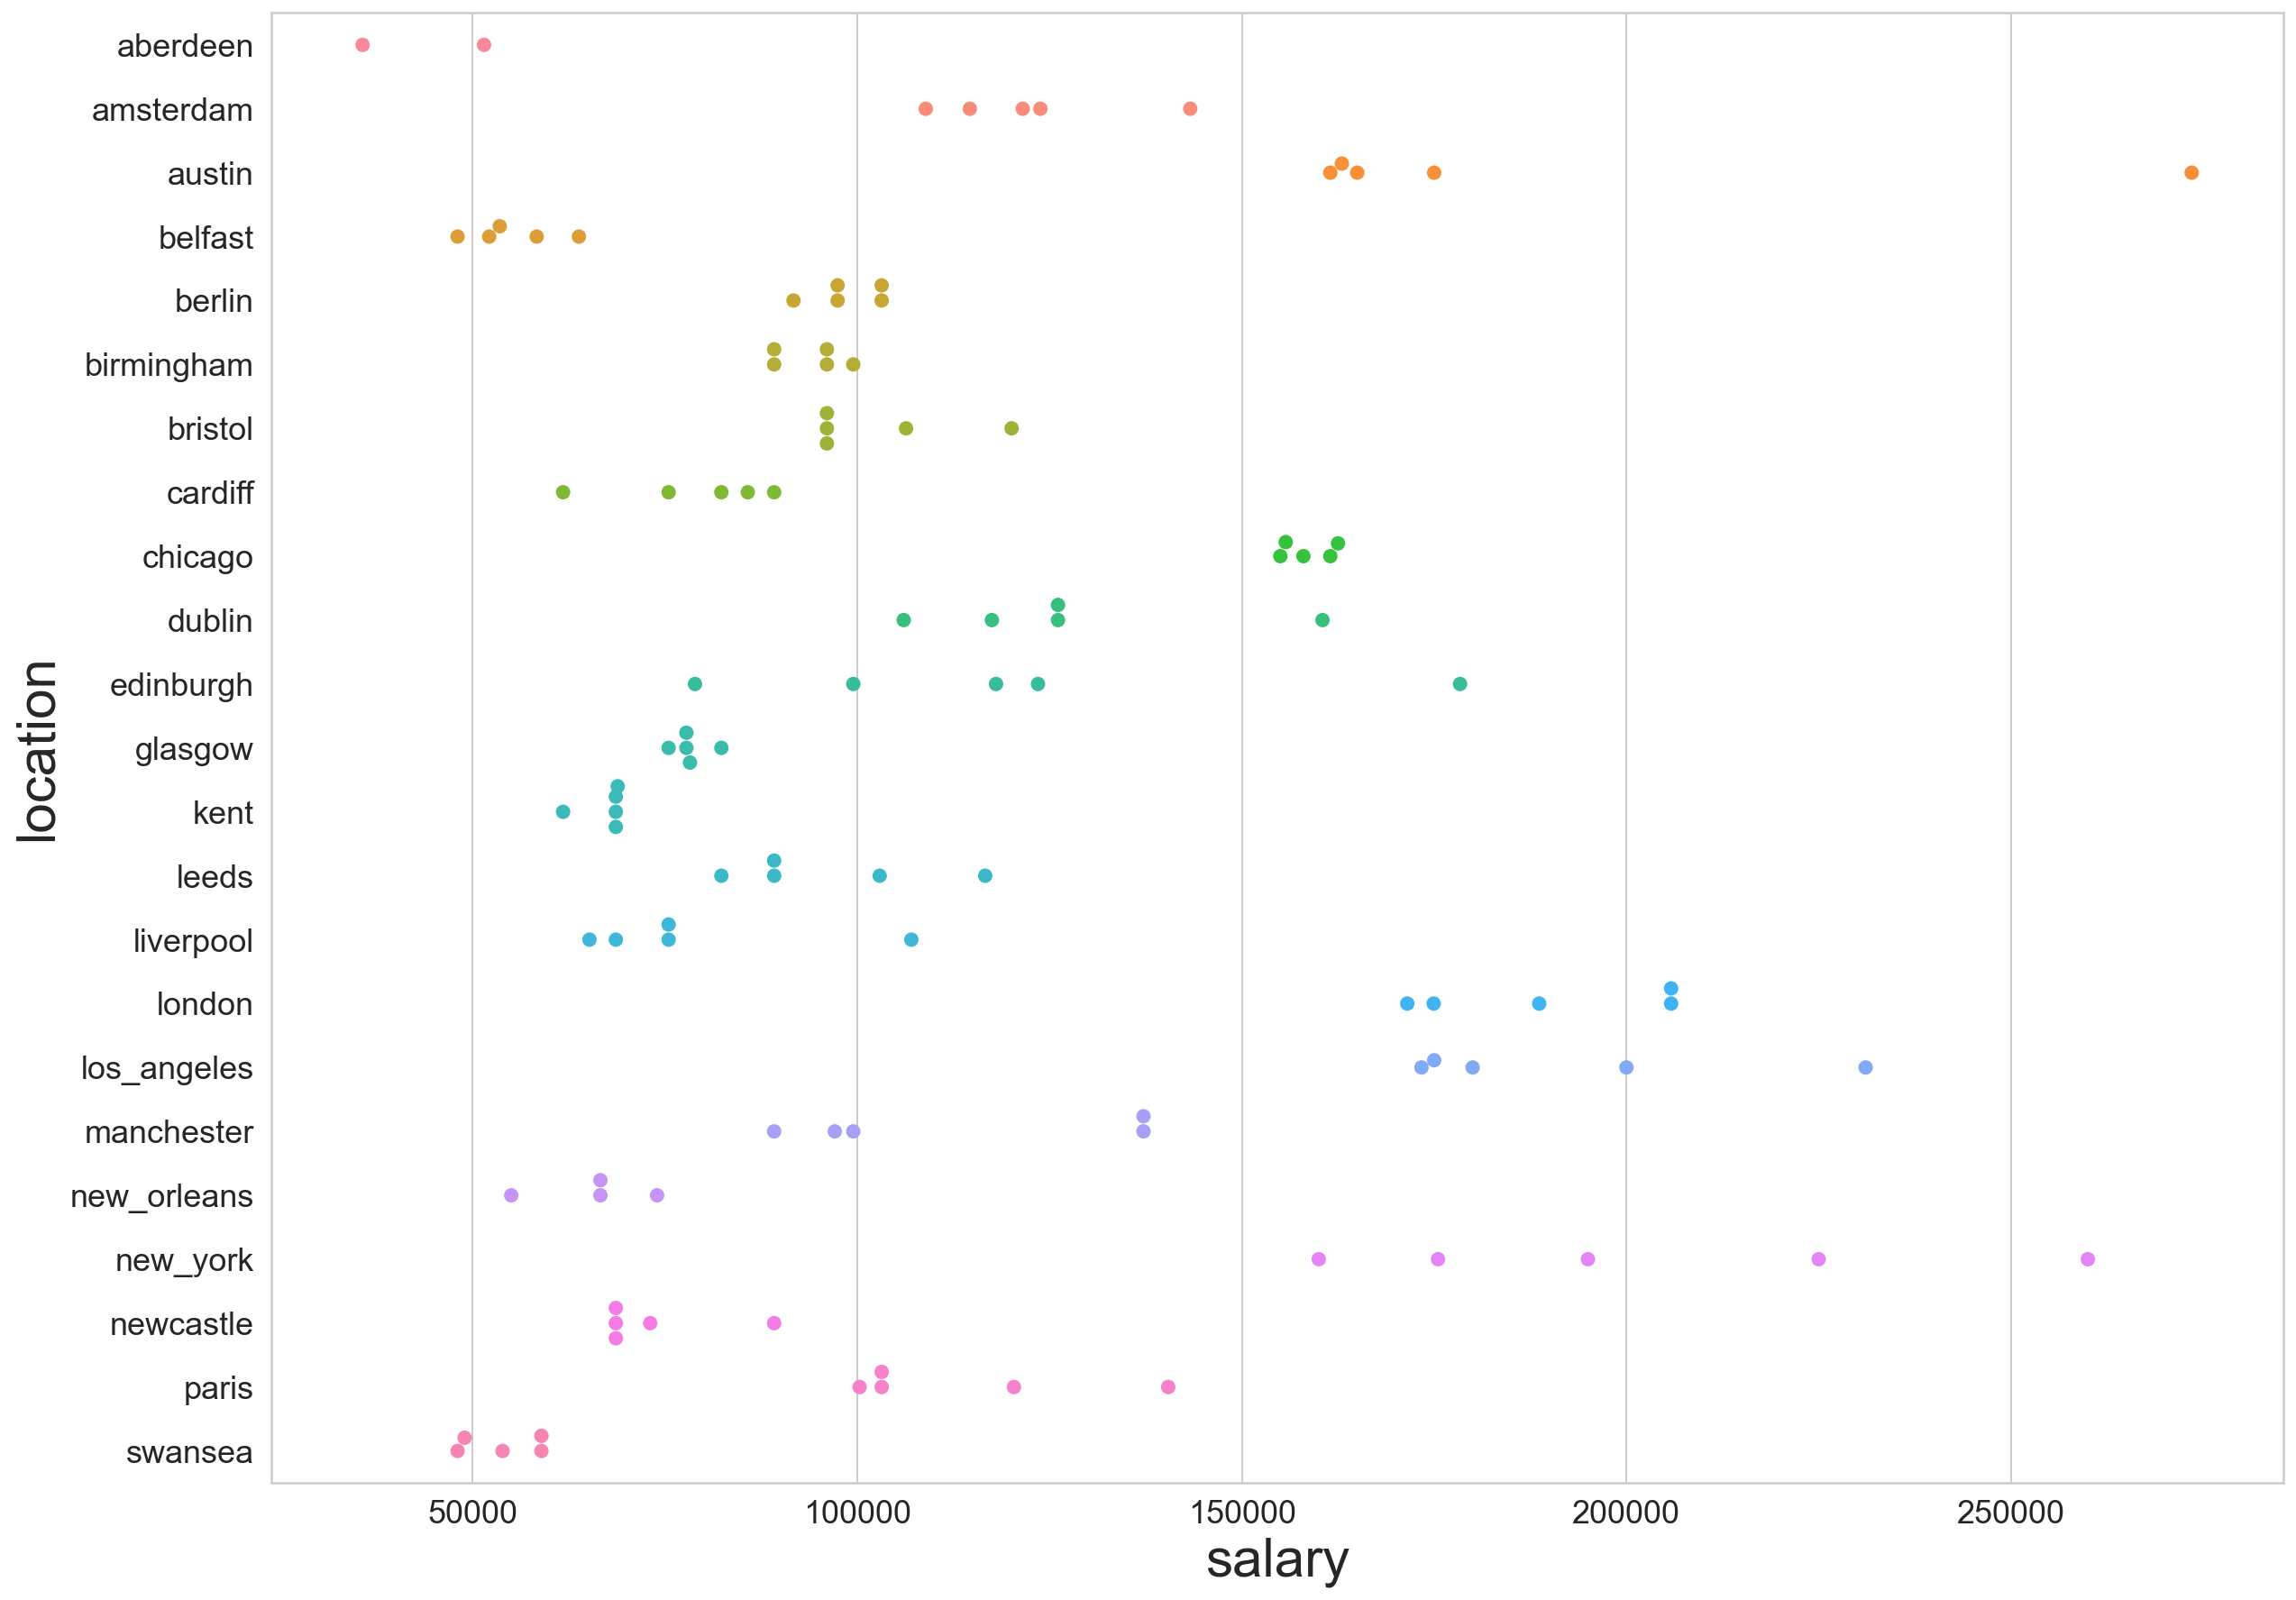

In [427]:
figure = plt.figure(figsize=(20,15))
plt.rcParams["axes.labelsize"] = 30
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

sns.swarmplot(data = top_5, x='salary', y='location', size=8)
plt.show();

This shows me that the highest earning potential appears to be in New York City with the 5th highest potential salary being above 150,000 USD p.a.

The highest salary for all jobs in the dataset is based in Austin, with a salary of approximately 275,000 USD p.a.
This salary, however is approximately 100,000 USD p.a. greater than the next 4 highest salaries for Austin. I want to investigate this data point further. It may warrant dropping.

The three cities with the lowest earning potential are Aberdeen, Swansea and Belfast. 

I also want to plot a boxplot of the salaries against location, to check outliers. I will use the salary z_score calculated above in the `z_salary` column.

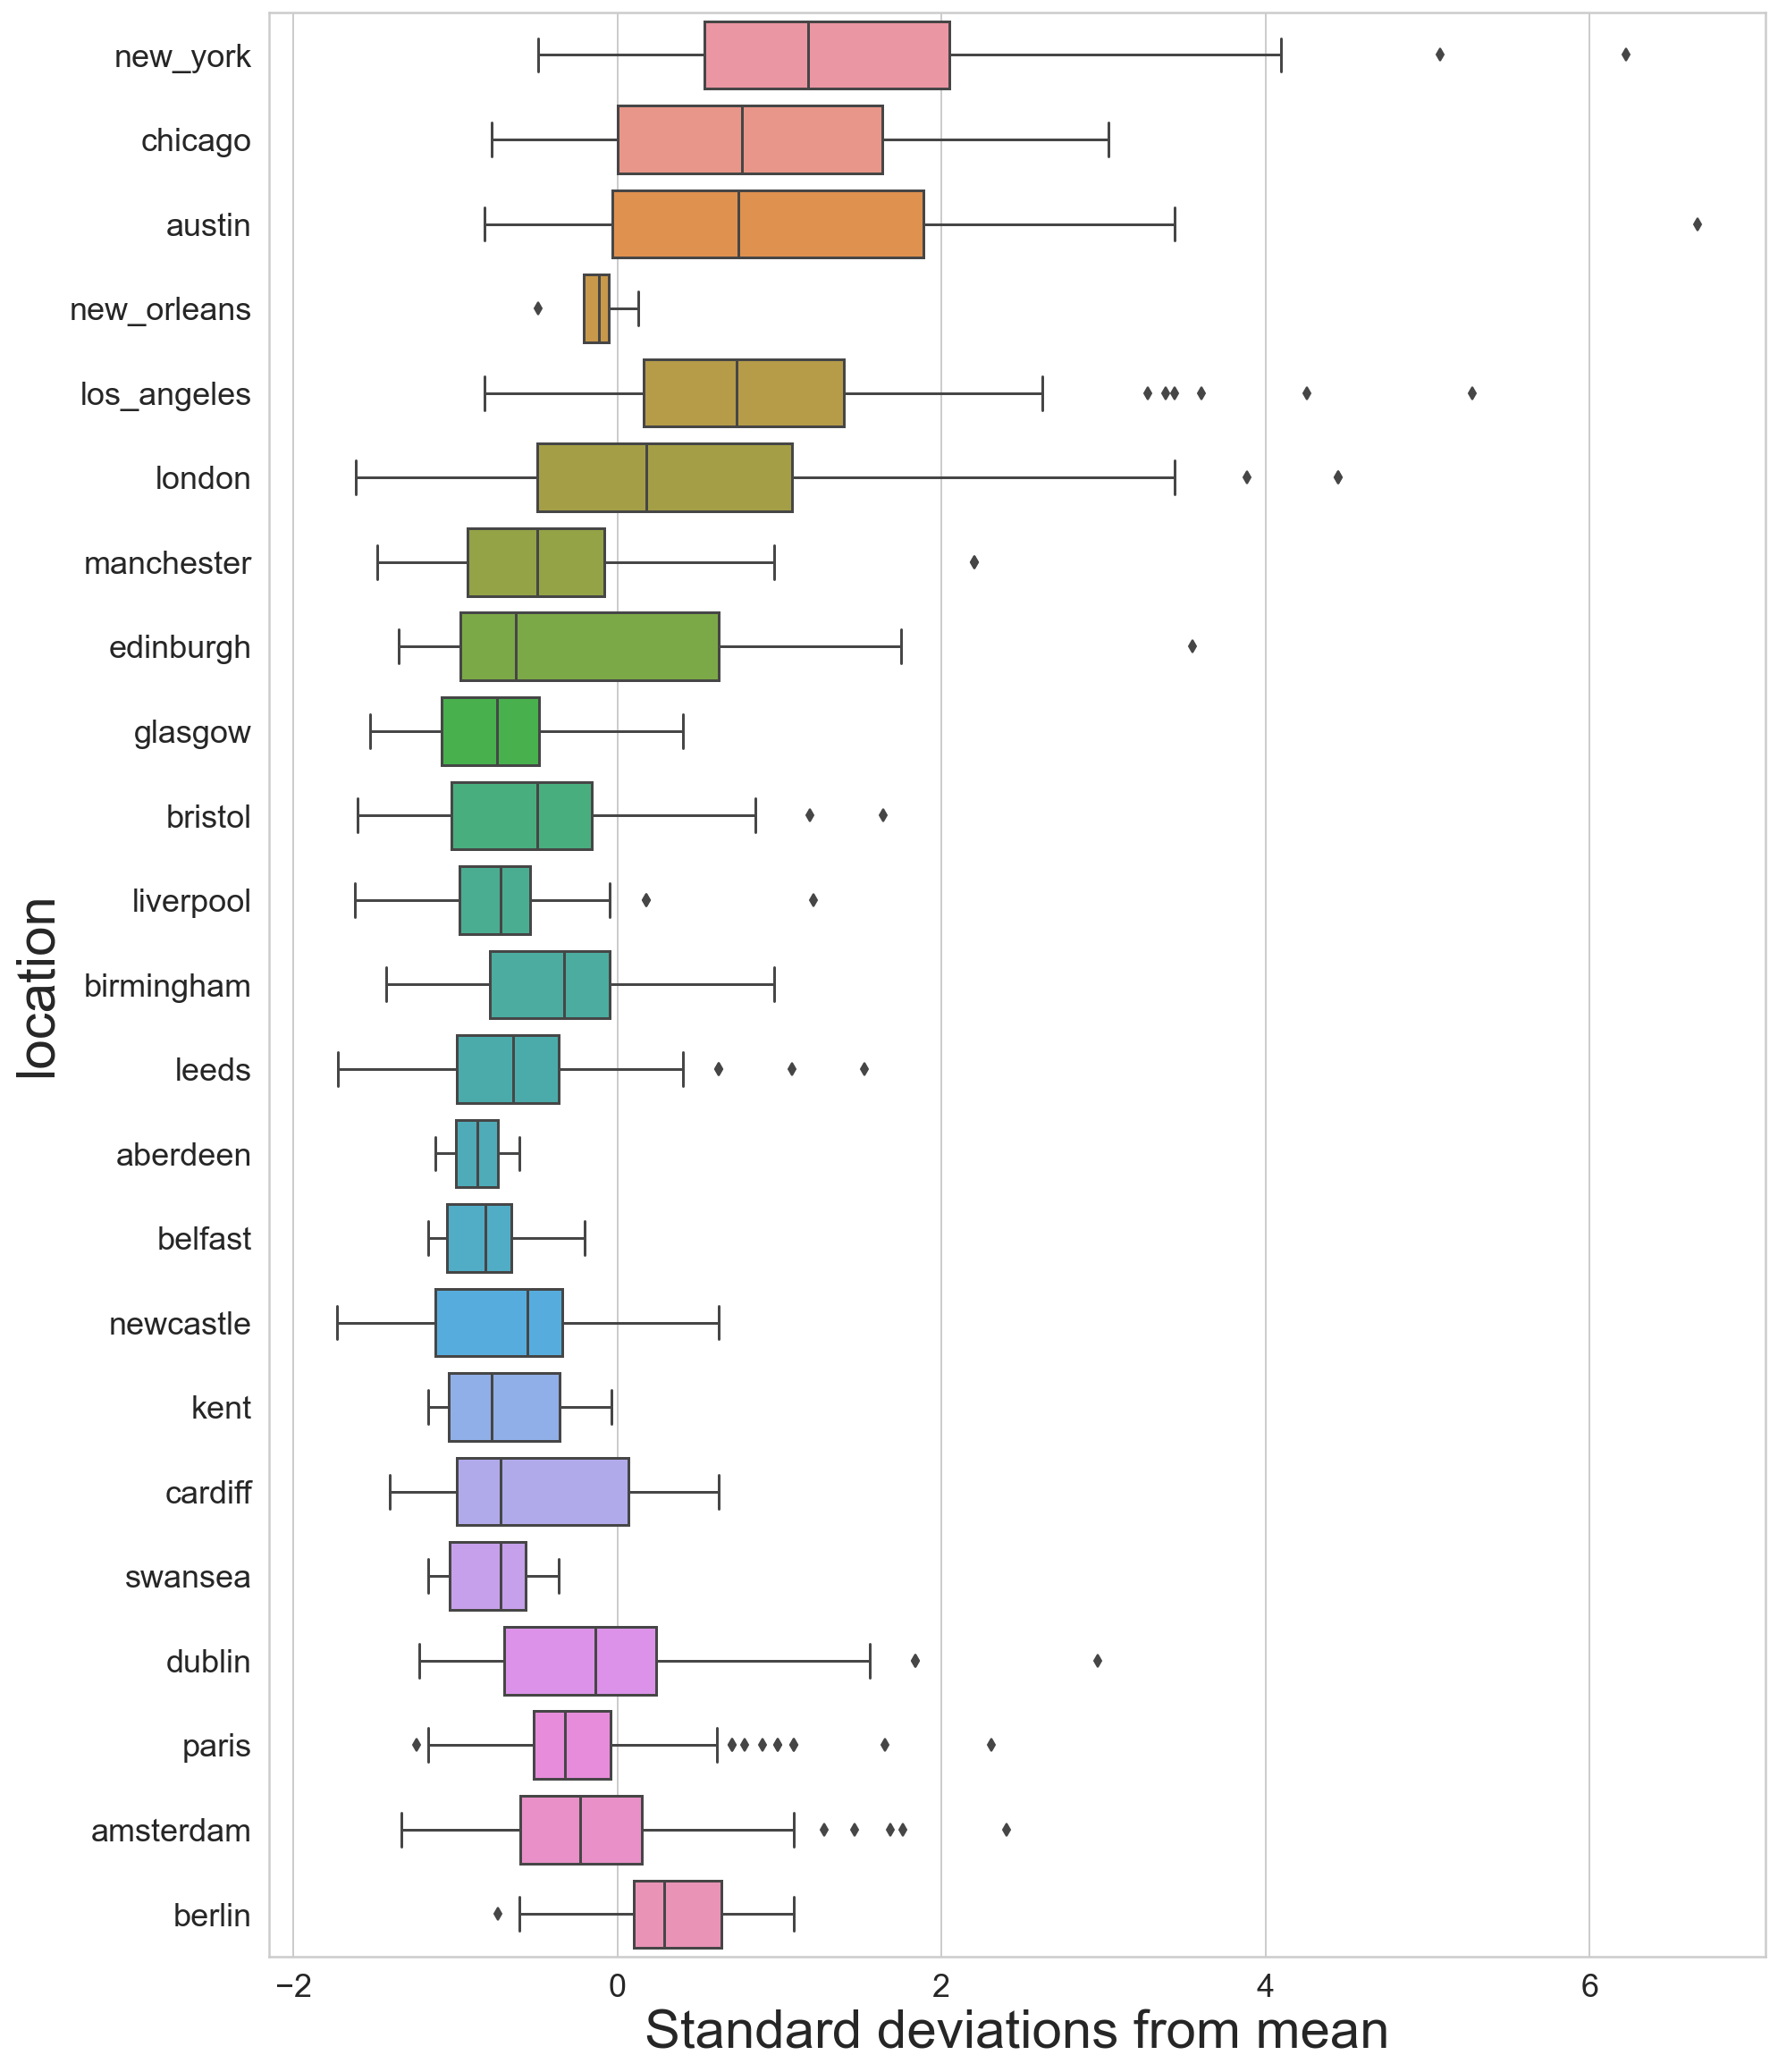

In [433]:
fig = plt.figure(figsize=(15,20))
sns.boxplot(x='z_salary',y='location',data=jobs,orient='h',whis=1.5)
plt.xlabel('Standard deviations from mean')
plt.show();

This boxplot shows there are several outliers across the following cities:
- New York City
- Austin
- New Orleans
- Los Angeles
- London
- Manchester
- Edinburgh
- Bristol
- Liverpool
- Leeds
- Dublin
- Paris
- Amsterdam
- Berlin

I think the outlier for Austin has the potential to throw off the predictions significantly because it is 6 standard deviations away from it's mean, and approximately 2 stadard deviations away from the 75th quartile, with no other intervening data points. As a result, I will drop this data point.

In [437]:
jobs.drop(175,inplace=True)
jobs.reset_index(drop = True, inplace=True)

### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

### Define salary bands

After analysing the distribution of salaries above, I think it is appropriate to introduce more salary bands than just HIGH/LOW since there is a number of very high salaries.

As a result of this, I will band the salaries based on the following percentiles:

|Category|Salary Band|Percentile|
|----|----|----|
|LOW|<= 48937.11|25th percentile|
|MID-LOW|48937.11 - 63046.50|50th percentile|
|MID-HIGH|63046.50 - 82400.00|75th percentile|
|HIGH|82400.00 < salary|100th percentile|

In [439]:
percentiles = jobs.salary.quantile(q=[0.25,0.5,0.75])

In [440]:
jobs.salary_band = jobs.salary.apply(lambda x: 'LOW' if x <= percentiles.loc[0.25] else 'MID-LOW' if x > percentiles.loc[0.25] and x <= percentiles.loc[0.5] else 'MID-HIGH' if x > percentiles.loc[0.5] and x <= percentiles.loc[0.75] else 'HIGH')

In [441]:
jobs.head()

job_title  location  \
0                                      Data Scientist  new_york   
1                                      Data Scientist  new_york   
2  Data Scientist II - Algorithmic Justice Specialist  new_york   
3                                      Data Scientist  new_york   
4                               Senior Data Scientist  new_york   

                     company    salary salary_band  z_salary  
0                NYC Careers   81167.0    MID-HIGH  0.364275  
1  Amazon Web Services, Inc.  114700.0        HIGH  1.462611  
2                       ACLU  115638.0        HIGH  1.493334  
3                   DojoMojo  121845.0        HIGH  1.696637  
4  Amazon Web Services, Inc.  116200.0        HIGH  1.511741

In [453]:
# jobs.to_csv(path_or_buf = 'final_jobs.csv', mode = 'w', header = True, index = False)

#### Thought experiment: What is the baseline accuracy for this model?

In [454]:
jobs = pd.read_csv('final_jobs.csv')

In [455]:
jobs.salary_band.value_counts()

MID-LOW     517
LOW         499
HIGH        497
MID-HIGH    473
Name: salary_band, dtype: int64

In [457]:
baseline_accuracy = 517/(517+499+497+473)

In [459]:
baseline_accuracy

0.26032225579053375

The baseline accuracy for this model is {{round(baseline_accuracy*100,2)}}%.

What this means is that if we if we predict the most frequent category (in this case 'LOW') then we will be correct {{round(baseline_accuracy*100,2)}}% of the time. 

For the classification model to be a success, we need to predict the correct category more than {{round(baseline_accuracy*100,2)}}% of the time.

### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

# Answer:

Initially I will create two models:
- Logistic Regression
- Decision Tree Classifier

These models will aim to predict the salary_band of each job based only on location.

I will use a grid search to tune and optimise these models.

In [512]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


## Train-Test Split

In [578]:
y = jobs.salary_band.copy()
X = pd.get_dummies(jobs.location, drop_first = True).copy()

sc = StandardScaler()

In [481]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [514]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [482]:
kf = StratifiedKFold(n_splits = 10)

## Location only

### Logistic Regression

#### First fit

In [515]:
loc1_lr = LogisticRegression(max_iter=1000)

In [516]:
loc1_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [857]:
loc1_lr_cv_score = cross_val_score(loc1_lr, X_train, y_train, cv = kf).mean()
loc1_lr_cv_score

0.44460632115277454

The above score is the accuracy score for this model. What this means is for all predictions the model makes, how many of them does it get right. In this instance, the model has an accuracy score of 44.46% which is an improvement on the baseling by approximately 20%.

#### Interpret coefficients and explain feature importances

When you are doing binary classification (e.g. HIGH vs. LOW) the logistic regression model has one set of coefficients for determining the class of an input. Since this model is a multiclass predictor, it operates on a one vs. rest model. This means it generates a different set of coefficients per class. (coefs_1: HIGH or NOT HIGH, coefs_2: LOW or NOT LOW, coefs_3: MID-HIGH or NOT MID-HIGH, coefs_4: MID-LOW or NOT MID-LOW)

The following is the best way to interpret the New York co-efficient for HIGH class (see table below):
A 1 unit increase in new_york means 0.571133 increase in the log-odds ratio that the salary_band will be HIGH.

The following tables will show feature importance for predicting each class. Feature importance ranks each predictor in terms of how much it contributes to a row being classified as HIGH, MID-HIGH, MID-LOW, and LOW.

In [590]:
loc1_lr_coefs = pd.DataFrame(loc1_lr.coef_, columns=X.columns,index=loc1_lr.classes_).transpose()

loc1_lr_coefs.HIGH.sort_values(ascending=False)

new_york       0.571133
chicago        0.369735
london         0.362999
los_angeles    0.311291
austin         0.292385
berlin         0.100986
dublin         0.043973
cardiff        0.018385
edinburgh     -0.033352
amsterdam     -0.036135
bristol       -0.048042
paris         -0.113216
new_orleans   -0.125081
manchester    -0.143372
swansea       -0.167141
newcastle     -0.187896
birmingham    -0.216314
belfast       -0.285584
liverpool     -0.316638
kent          -0.366645
leeds         -0.369056
glasgow       -0.439119
Name: HIGH, dtype: float64

For predicting {{class_coefs.columns[0]}}, the top 3 most important features are: 
- new_york
- chicago
- london

In [591]:
loc1_lr_coefs.LOW.sort_values(ascending=False)

liverpool      0.348493
leeds          0.308128
glasgow        0.254218
belfast        0.231935
swansea        0.222187
kent           0.221137
birmingham     0.155630
newcastle      0.132809
manchester     0.131510
bristol        0.092267
cardiff        0.091251
edinburgh      0.076273
dublin         0.047380
amsterdam     -0.026166
london        -0.071832
paris         -0.088478
austin        -0.090928
berlin        -0.092583
new_orleans   -0.133473
los_angeles   -0.218046
chicago       -0.430339
new_york      -0.679356
Name: LOW, dtype: float64

For predicting {{class_coefs.columns[1]}}, the top 3 most important features are: 
- liverpool
- leeds
- glasgow

In [592]:
loc1_lr_coefs['MID-HIGH'].sort_values(ascending=False)

new_orleans    0.158773
new_york       0.131570
chicago        0.126029
glasgow        0.075596
amsterdam      0.073239
berlin         0.052407
kent           0.049114
paris          0.041641
birmingham     0.034502
los_angeles    0.029129
dublin         0.010358
newcastle      0.008139
belfast       -0.000878
austin        -0.002193
manchester    -0.005065
edinburgh     -0.018477
leeds         -0.047352
bristol       -0.064765
cardiff       -0.080191
london        -0.151850
liverpool     -0.154477
swansea       -0.192629
Name: MID-HIGH, dtype: float64

For predicting {{class_coefs.columns[2]}}, the top 3 most important features are: 
- new_orleans
- new_york
- chicago

In [593]:
loc1_lr_coefs['MID-LOW'].sort_values(ascending=False)

paris          0.160053
swansea        0.137583
liverpool      0.122622
glasgow        0.109305
leeds          0.108280
new_orleans    0.099781
kent           0.096394
belfast        0.054528
newcastle      0.046949
birmingham     0.026182
bristol        0.020539
manchester     0.016927
amsterdam     -0.010938
new_york      -0.023347
edinburgh     -0.024444
cardiff       -0.029445
berlin        -0.060810
chicago       -0.065424
dublin        -0.101712
los_angeles   -0.122374
london        -0.139316
austin        -0.199263
Name: MID-LOW, dtype: float64

For predicting {{class_coefs.columns[3]}}, the top 3 most important features are: 
- paris
- swansea
- liverpool

### Decision Tree Classifier

#### First fit

In [533]:
loc1_dt = DecisionTreeClassifier()
loc1_dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [637]:
loc1_dt_cv_score = cross_val_score(loc1_dt, X_train, y_train, cv= kf).mean()

loc1_dt_cv_score 

0.44837990605843486

The above score is the accuracy score for this model. What this means is for all predictions the model makes, how many of them does it get right. In this instance, the model has an accuracy score of 44.84% which is an improvement on the baseline by approximately 20%.

It is also an improvement on the above Logistic Regression model by 0.47%.

In [638]:
loc1_dt.score(X_test, y_test)

0.457286432160804

It is also especially important to confirm for Decision Trees that they are not overfitting to the training data. It is very easy for these models to overfit because they can continue to add depth until they have classified everything correctly.

A score of 0.4573 on unseen test data shows me that is has not overfit to the training data.

#### Feature Importances

In [541]:
dt_ftr_importance = pd.DataFrame(zip(X.columns,loc1_dt.feature_importances_), columns=['feature','importance'])
dt_ftr_importance.sort_values(by='importance',ascending=False)

feature  importance
18     new_york    0.177610
14       london    0.131279
1        austin    0.126837
7       chicago    0.126812
15  los_angeles    0.123251
0     amsterdam    0.098483
20        paris    0.071418
3        berlin    0.033589
8        dublin    0.031436
13    liverpool    0.020967
17  new_orleans    0.012984
2       belfast    0.012370
4    birmingham    0.008374
5       bristol    0.006038
16   manchester    0.005619
21      swansea    0.003663
6       cardiff    0.003432
12        leeds    0.003154
19    newcastle    0.001598
9     edinburgh    0.000992
11         kent    0.000094
10      glasgow    0.000000

For decision trees, the 'co-efficients' attributed to different features are easier to interpret than for Logistic Regression models.

The higher the number for a given predictor, the more important it was for deciding splits at different nodes in the decision tree. 

A feature is more important if:
- It is used to decide how to split at many different nodes
- If the difference in the measure of Gini or entropy before the split and after the split are high. (For this model we used Gini as the default.) 

Gini is calculated in the following way:

$Gini = 1 - \sum_{i =1}^{no. of classes}(\frac{size-of-class}{total-population})^{2}$

e.g.

members_per_class = [5,5,10] where each index position is a different class.

$Gini = 1 - ((\frac{5}{20})^{2}+(\frac{5}{20})^{2}+(\frac{10}{20})^{2})$

$Gini = 1 - (0.0625 + 0.0625 + 0.25)$

$Gini = 1 - 0.375$

$Gini = 0.625$

## Feature Engineering

### Grouping jobs by level

In [545]:
pd.DataFrame(jobs.job_title.unique(), columns=['unique_titles'])

unique_titles
0                                                   Data Scientist
1               Data Scientist II - Algorithmic Justice Specialist
2                                            Senior Data Scientist
3                                                   DATA SCIENTIST
4                                             Staff Data Scientist
5                                              Lead Data Scientist
6                  Senior Data Analyst/Data Scientist/Data Analyst
7                                               Sr. Data Scientist
8                                   Product Analyst/Data Scientist
9                       Associate Data & Machine Learning Engineer
10                             Environmental Health Data Scientist
11                                           Chief Data Scientist 
12                        City Research Scientist I / Data Analyst
13                         Associate Partner, Enterprise Strategy 
14               Senior Data Analyst - Visualization and Reporting
15                  City Research Scientist III / Director of Data
16             Senior Data Analyst, Bureau of Tuberculosis Control
17                                          Sr. Data & ML Engineer
18                         Machine Learning Visualization Engineer
19             City Research Scientist I / Policy and Data Analyst
20                             Senior Data Scientist- Boost Mobile
21         Data Engineer - Data Science Platforms & Infrastructure
22                    Senior Data Analyst, Mayor's Office of M/WBE
23                                                   Data Engineer
24                                         Senior Research Analyst
25                                    Data Scientist- Test & Trace
26                                  Data Scientist – Deep learning
27                                        Principal Data Scientist
28                                                     Researcher 
29                                       Full Stack Data Scientist
30                                         Quantitative Researcher
31                             Business Analysts with Data Science
32                                                  Data Architect
33                                   Data Analyst / Data Scientist
34                                             1628 Data Scientist
35                                       Machine Learning Engineer
36                             Senior Analyst, Learning Management
37                                    Senior Analyst, Service Desk
38                      Product Analyst-Enterprise Data Management
39                                      Technical Business Analyst
40                                      Technology Project Analyst
41                                 Analyst, Procurement Operations
42                                                Business Analyst
43                                      Senior IT Business Analyst
44                                                Data Engineer II
45                             Data Engineer - Marketing Analytics
46                                         Staff Software Engineer
47                                              Lead Data Engineer
48                             Data Analyst/ Engineer/ Entry Level
49                       Cybersecurity Vulnerability Data Engineer
50                                                  Data Engineer!
51                                     Fan Data Solutions Engineer
52                                           Data Engineer Level I
53                                               Sr Data Engineer 
54                                        Data Engineer/Architect 
55        Software Engineer - Data Engineering / Python / REST API
56                                                Data QC Engineer
57                Senior Systems Engineer | Data Center Operations
58                           Data Scientist - Operations Research 
59                               

In [547]:
# List of tags attached to job title to indicate seniority
indicators = {
    'senior': ['Senior', 'Lead', 'Sr.', 'Sr', 'Chief', 'Principal', 'Manager', 'Director', 'Head', 'Specialist'],
    'junior': ['Entry', 'Junior', 'I', '1', 'graduate', 'Apprenticeship', 'Apprentice', 'Internship', 'Interim', 'Trainee', 'Traineeship']
}

In [550]:
def cat_job(job_title):
    check = str()
    for key, val in indicators.items():
        for tag in val:
            if tag in job_title:
                return key
    return 'mid_level'

In [562]:
jobs['seniority'] = jobs.job_title.apply(cat_job).copy()

In [568]:
jobs['is_engineer'] = jobs.job_title.apply(lambda x: 1 if 'engineer' in x.lower() else 0).copy()

## Re-modelling with more predictors

### Train-Test Split

In [575]:
jobs.columns

Index(['job_title', 'location', 'company', 'salary', 'salary_band', 'z_salary',
       'seniority', 'is_engineer'],
      dtype='object')

In [584]:
X2 = pd.get_dummies(jobs[['seniority','is_engineer','location']],drop_first=True)
sc=StandardScaler()
kf = StratifiedKFold(n_splits = 10)

In [580]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size = 0.2, stratify = y)

In [581]:
X2_train = sc.fit_transform(X2_train)
X2_test = sc.transform(X2_test)

### Logistic Regression

In [582]:
remod_lr = LogisticRegression(max_iter=1000)

In [583]:
remod_lr.fit(X2_train,y2_train)

LogisticRegression(max_iter=1000)

In [585]:
remod_lr_cv_score = cross_val_score(remod_lr, X2_train, y2_train, cv=kf).mean()

In [587]:
remod_lr_cv_score

0.49433564206671443

For the above model using predictors indicating the seniority of a position, if it has engineer in the title, and location, we have a cross validation score of {{remod_lr_cv_score}}.

This an improvement of {{round(remod_lr_cv_score - loc1_lr_cv_score, 2)}} on the cross validation score for the first logistic regression model.

This means the second model will predict the correct category for salary band 5% more often than the first model.

#### Interpreting coefficients and feature importance

In [596]:
remod_lr_coefs = pd.DataFrame(remod_lr.coef_, columns=X2.columns,index=remod_lr.classes_).transpose()

remod_lr_coefs.HIGH.sort_values(ascending=False)

seniority_senior        0.703916
location_new_york       0.601895
is_engineer             0.450666
location_london         0.450655
location_chicago        0.437832
location_los_angeles    0.375920
location_austin         0.313633
seniority_mid_level     0.064298
location_berlin         0.060764
location_edinburgh      0.055819
location_cardiff        0.043492
location_dublin         0.034160
location_amsterdam     -0.019693
location_bristol       -0.053664
location_new_orleans   -0.093608
location_newcastle     -0.126180
location_paris         -0.131536
location_manchester    -0.168584
location_birmingham    -0.174095
location_swansea       -0.175030
location_belfast       -0.260327
location_liverpool     -0.267841
location_leeds         -0.309047
location_kent          -0.387329
location_glasgow       -0.420451
Name: HIGH, dtype: float64

We can see from the above table the following three features are most important for predicting a HIGH salary:
- seniority_senior
- location_new_york
- is_engineer

To reiterate the explanation given above during the first discussion of coefficients for a Logistic Regression model:
For `seniority_senior` the coefficient is 0.703916. This means that for every unit increase in `seniority_senior` there will be a corresponding increase of 0.703916 for the log_odds of the salary for that job being HIGH accorsding to this model.

I will now continue to list the three most important features the rest of the classes in this model: LOW, MIG-HIGH, MID-LOW

In [597]:
remod_lr_coefs.LOW.sort_values(ascending=False)

location_liverpool      0.277253
location_leeds          0.233849
location_kent           0.218251
location_swansea        0.210945
location_glasgow        0.203106
location_belfast        0.178642
location_manchester     0.119114
location_newcastle      0.089555
location_birmingham     0.086749
location_bristol        0.055089
location_cardiff        0.049593
location_edinburgh      0.025287
location_dublin         0.010851
location_berlin        -0.085988
seniority_mid_level    -0.086783
location_austin        -0.103259
location_paris         -0.117864
location_amsterdam     -0.129703
location_new_orleans   -0.159915
location_los_angeles   -0.268079
location_london        -0.272045
is_engineer            -0.308737
location_chicago       -0.487011
seniority_senior       -0.679275
location_new_york      -0.720829
Name: LOW, dtype: float64

TOP 3 features for predicting a low salary:
- location_liverpool
- location_leeds
- location_kent

In [598]:
remod_lr_coefs['MID-HIGH'].sort_values(ascending=False)

location_amsterdam      0.229898
seniority_senior        0.220167
location_new_york       0.189661
location_chicago        0.180554
location_new_orleans    0.176978
location_paris          0.123813
location_birmingham     0.116990
location_glasgow        0.113376
location_dublin         0.102458
location_kent           0.100663
location_berlin         0.094929
location_los_angeles    0.077525
location_london         0.068891
location_newcastle      0.043964
location_belfast        0.031961
location_manchester     0.029581
location_bristol        0.024457
location_austin         0.019158
location_leeds          0.014281
seniority_mid_level    -0.004673
location_cardiff       -0.009773
location_edinburgh     -0.010846
is_engineer            -0.024946
location_liverpool     -0.084329
location_swansea       -0.189262
Name: MID-HIGH, dtype: float64

Top 3 features for predicting a MID-HIGH salary:
- location_amsterdam
- seniority_senior
- location_new_york

In [599]:
remod_lr_coefs['MID-LOW'].sort_values(ascending=False)

location_swansea        0.153347
location_paris          0.125588
location_glasgow        0.103968
location_new_orleans    0.076544
location_liverpool      0.074918
location_kent           0.068415
location_leeds          0.060916
location_belfast        0.049724
seniority_mid_level     0.027158
location_manchester     0.019888
location_newcastle     -0.007339
location_bristol       -0.025882
location_birmingham    -0.029644
location_berlin        -0.069704
location_edinburgh     -0.070260
location_new_york      -0.070728
location_amsterdam     -0.080502
location_cardiff       -0.083312
is_engineer            -0.116983
location_chicago       -0.131375
location_dublin        -0.147469
location_los_angeles   -0.185366
location_austin        -0.229531
seniority_senior       -0.244808
location_london        -0.247501
Name: MID-LOW, dtype: float64

Top 3 features for predicting a MID-LOW salary:
- location_swansea
- location_paris
- location_glasgow

#### Model tuning

I will finally tune this model to ensure I find the optimal hyperparameters for this Logistic Regression. TO achieve this I will use GridSearchCV.

In [612]:
remod_lr_tuned = LogisticRegression(max_iter = 10000)

remod_lr_params = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-1,0,100,float),
    'solver': ['liblinear']
}

remod_gslr = GridSearchCV(remod_lr_tuned,remod_lr_params, cv=kf)

remod_gslr.fit(X2_train, y2_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': array([0.1       , 0.1023531 , 0.10476158, 0.10722672, 0.10974988,
       0.1123324 , 0.1149757 , 0.1176812 , 0.12045035, 0.12328467,
       0.12618569, 0.12915497, 0.13219411, 0.13530478, 0.13848864,
       0.14174742, 0.14508288, 0.14849683, 0.15199111, 0.15556...
       0.5094138 , 0.52140083, 0.53366992, 0.54622772, 0.55908102,
       0.57223677, 0.58570208, 0.59948425, 0.61359073, 0.62802914,
       0.64280731, 0.65793322, 0.67341507, 0.68926121, 0.70548023,
       0.7220809 , 0.7390722 , 0.75646333, 0.77426368, 0.7924829 ,
       0.81113083, 0.83021757, 0.84975344, 0.869749  , 0.89021509,
       0.91116276, 0.93260335, 0.95454846, 0.97700996, 1.        ]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

#### Best estimator

In [614]:
remod_gslr.best_estimator_

LogisticRegression(C=0.1, max_iter=10000, penalty='l1', solver='liblinear')

Using the best estimator attribute, we can see the best estimator uses L1 (Lasso) penalty with a C value of 0.1.

This penalty is useful as it zeroes out redundant features. Since we have many predictors, it may be possible that some are redundant.

#### Best Cross Validated Score

In [678]:
tuned_lr_cv_score = remod_gslr.best_score_
tuned_lr_cv_score

0.48362789586816335

After optimising the model, the best cross validated score is {{round(remod_gslr.best_score_, 4)}}. 

This is marginally worse than the score for the unoptimised logistic regression model: {{round(remod_lr_cv_score,4)}}.

This is expected, however, and the difference is small, so can be explained by difference in sampling.

In [681]:
remod_gslr.score(X2_test, y2_test)

0.5

We can see the score for this model on unseen data is 0.5 This shows me again the model has not overfit to the data and it is predicting the correct category exactly 50% of the time.

#### Model coefficients

In [663]:
lr_tuned = LogisticRegression(C=0.1, max_iter=10000, penalty='l1', solver='liblinear')
lr_tuned.fit(X2_train,y2_train)

LogisticRegression(C=0.1, max_iter=10000, penalty='l1', solver='liblinear')

In [664]:
tuned_lr_coefs = pd.DataFrame(lr_tuned.coef_, columns = X2.columns, index=remod_lr_tuned.classes_).transpose()

tuned_lr_coefs['HIGH'].sort_values(ascending=False)

seniority_senior        0.641735
location_london         0.613314
location_new_york       0.597498
is_engineer             0.511904
location_chicago        0.460097
location_los_angeles    0.444827
location_austin         0.393212
location_berlin         0.040534
location_dublin         0.036337
location_new_orleans    0.000000
seniority_mid_level     0.000000
location_edinburgh      0.000000
location_cardiff        0.000000
location_bristol        0.000000
location_amsterdam      0.000000
location_swansea       -0.013621
location_newcastle     -0.022184
location_belfast       -0.032870
location_manchester    -0.068213
location_paris         -0.077898
location_birmingham    -0.081397
location_kent          -0.084154
location_glasgow       -0.089160
location_liverpool     -0.126466
location_leeds         -0.185926
Name: HIGH, dtype: float64

For the optimised model, when predicting HIGH salaries the penalty function has zeroed out the following columns:
- location_new_orleans
- seniority_mid_level
- location_edinburgh
- location_cardiff
- location_bristol
- location_amsterdam

This implies these variables are redundant when predicitng if the salary will be high.

In [665]:
tuned_lr_coefs['LOW'].sort_values(ascending=False)

location_liverpool      0.302340
location_leeds          0.284215
location_kent           0.165090
location_manchester     0.146481
location_belfast        0.144468
location_glasgow        0.132603
location_birmingham     0.131604
location_newcastle      0.114150
location_bristol        0.096071
location_swansea        0.095294
location_cardiff        0.087325
location_dublin         0.062430
location_edinburgh      0.053829
location_berlin         0.000000
location_amsterdam      0.000000
seniority_mid_level    -0.032836
location_austin        -0.035253
location_new_orleans   -0.050234
location_paris         -0.069203
location_london        -0.105525
location_los_angeles   -0.183900
is_engineer            -0.300424
location_chicago       -0.326076
location_new_york      -0.365884
seniority_senior       -0.642342
Name: LOW, dtype: float64

For the LOW salary band, there are two redundant variables:
- location_berlin
- location_amsterdam

This informs us that the variables above are not entirely redundant as well. Despite being zeroed out when predicting HIGH salary, they have not been zeroed out here, implying they have some predictive power. However, for seniority_mid_level and location_edinburgh, the coefficients are still very small, meaning a one unit change in those predictors has a samll impact on the logodds of the salary being LOW.

In some circumstances it may be appropriate to remove location_edinburgh and seniority_mid_level among other predictors too since their effect of the logodds of the salary being LOW is small. It may be appropriate for example if you need the model to work very quickly, and need to trim predictors in order to optimise speed at the expense of some accuracy.

In [666]:
tuned_lr_coefs['MID-HIGH'].sort_values(ascending=False)

location_amsterdam      0.214342
seniority_senior        0.130779
location_new_orleans    0.091435
location_dublin         0.079309
location_birmingham     0.053254
location_berlin         0.048974
location_paris          0.033560
location_chicago        0.005948
location_edinburgh      0.000000
location_glasgow        0.000000
location_london         0.000000
location_newcastle      0.000000
location_kent           0.000000
location_cardiff        0.000000
seniority_mid_level     0.000000
location_manchester     0.000000
location_bristol        0.000000
location_los_angeles    0.000000
location_belfast       -0.019849
is_engineer            -0.032065
location_austin        -0.042209
location_new_york      -0.066735
location_swansea       -0.070922
location_leeds         -0.079468
location_liverpool     -0.166239
Name: MID-HIGH, dtype: float64

For MID-HIGH salaries, these are the zeroed out variables:
- location_edinburgh
- location_glasgow
- location_london
- location_newcastle
- location_kent
- location_cardiff
- seniority_mid_level
- location_manchester
- location_bristol
- location_los_angeles

This category has many redundant variable, some of which are important for predicting other categories. e.g. location_london is the second most important predictor for predicting a HIGH salary.

There are some repeat offenders, however:
- location_edinburgh
- seniority_mid_level

This makes my intution strong that I would drop these columns. Let's check the final category first though.

In [667]:
tuned_lr_coefs['MID-LOW'].sort_values(ascending=False)

location_paris          0.290650
location_amsterdam      0.070688
location_leeds          0.050325
seniority_mid_level     0.038203
location_manchester     0.028961
location_bristol        0.010594
location_swansea        0.006468
location_newcastle      0.000000
location_belfast        0.000000
location_birmingham     0.000000
location_new_orleans    0.000000
location_liverpool      0.000000
location_glasgow        0.000000
location_kent           0.000000
location_berlin        -0.013113
location_edinburgh     -0.016629
location_cardiff       -0.026948
location_dublin        -0.044324
location_london        -0.055889
is_engineer            -0.112809
location_chicago       -0.124462
location_los_angeles   -0.139303
location_austin        -0.154818
location_new_york      -0.182927
seniority_senior       -0.288878
Name: MID-LOW, dtype: float64

Finally, the redundant columns for the MID-LOW salary band:
- location_newcastle
- location_belfast
- location_birmingham
- location_new_orleans
- location_liverpool
- location_glasgow
- location_kent

These are all the zeroed out columns, however many columns have very small values, implying low predictive power. To further tune this model, I would drop redundant columns from my predictor variables.

### Create a classification model to predict High/Low salary. 

- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

## Decision Tree Classifier

In [644]:
from sklearn.tree import export_graphviz
import graphviz

In [650]:
remod_dtc = DecisionTreeClassifier()

remod_dtc_params = {
    'criterion': ['gini','entropy'],
    'max_depth': [5,6,7,8,9,10],
    'max_features': np.linspace(0.5, 0.8, 10, float)
}

remod_gsdtc = GridSearchCV(remod_dtc, remod_dtc_params)
remod_gsdtc.fit(X2_train, y2_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9, 10],
                         'max_features': array([0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
       0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ])})

#### Best estimator

In [651]:
dtc_tuned=remod_gsdtc.best_estimator_

dtc_tuned.fit(X2_train,y2_train)

DecisionTreeClassifier(max_depth=10, max_features=0.6333333333333333)

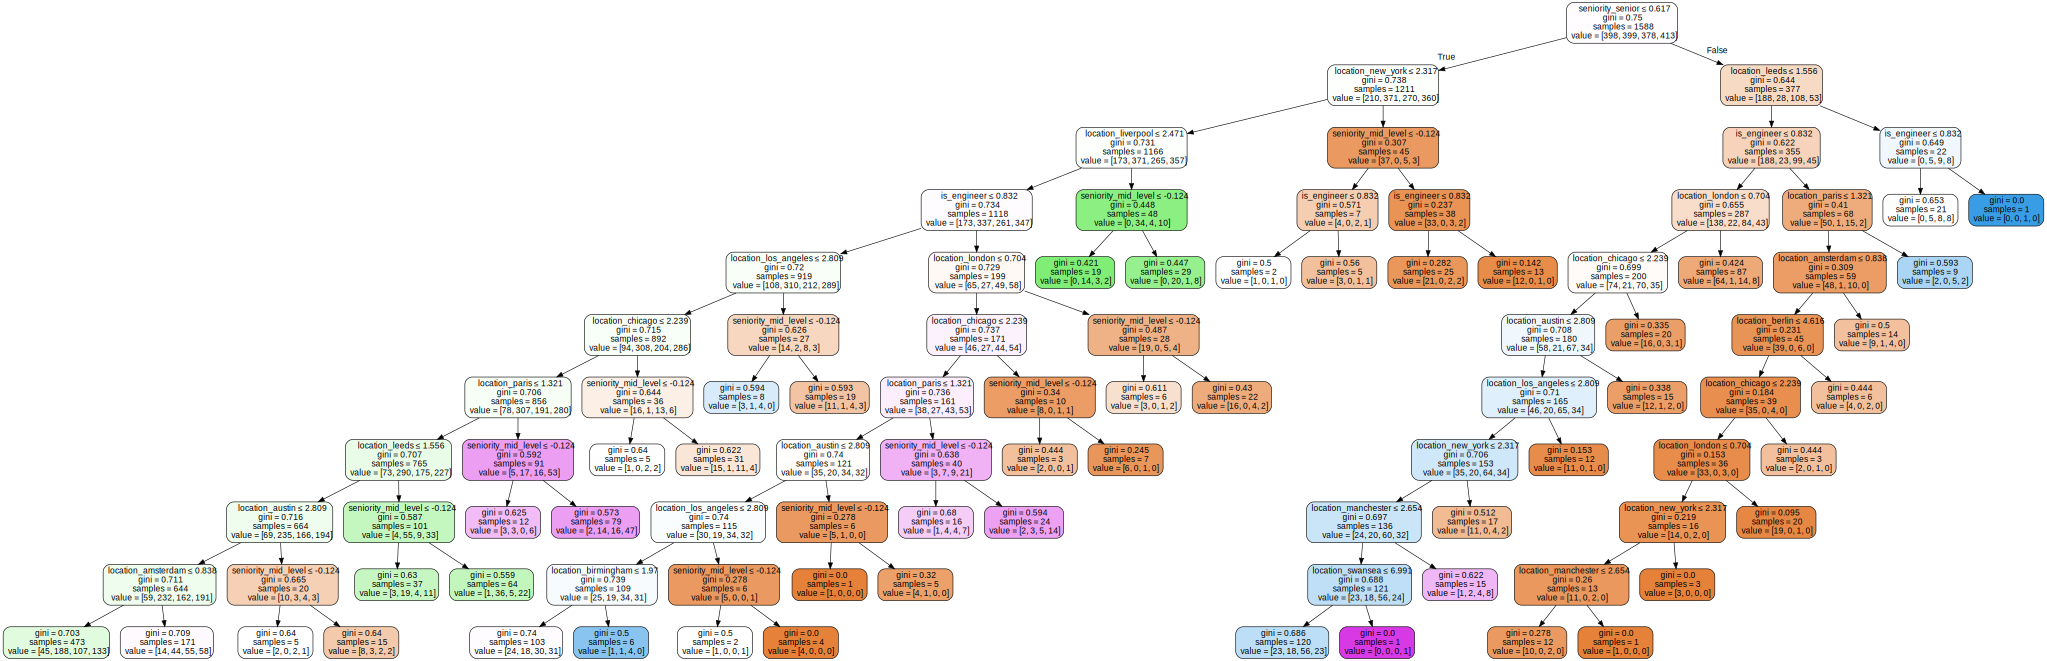

In [652]:
dot_data = export_graphviz(dtc_tuned,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=X2.columns
                )

graph = graphviz.Source(dot_data) 

graph

We can see above that the best estimator uses the entropy criterion, has max_features = 0.5 and min_samples_split = 0.04285714342857143.

Let me define each of these in turn:

#### criterion = entropy

Entropy is a measure of disorder, high entropy means high disorder. The splitter argument for this model is set to 'best', this is the default and it means that at each node the tree will choose the best split to efficiently classify each row. To calculate the best split, the model uses the entropy criterion and measures how disordered each leaf branching from that node is. The best split is that which minimises entropy within the new leaves.

#### max_features = 0.5

This determines the number of features the model is to use to determine the best split. A value of 0.5 means the model can use half of the total features to determine the best split.

#### max_depth = 10

This determines the maximum number of levels the tree can branch down. It is important to limit this to prevent overfitting.

#### Best cross validated score

In [848]:
dtc_tuned_cv_score = cross_val_score(dtc_tuned, X2_train, y2_train, cv=kf).mean()
dtc_tuned_cv_score 

0.48043547488257304

For this model, the cross validated score is 0.4817. This means that the model has an accuracy score of 48.17%. This means of all it's predictions 48.17% of them are correct.

To confirm it has not overfitted to the training data, I will now score it on the test data.

In [679]:
dtc_tuned.score(X2_test, y2_test)

0.5025125628140703

We can see the score on the test data is 0.5, which is an improvement on the cross-val score above. This shows me this model has not overfitted.


#### Feature importances

In [661]:
pd.DataFrame(zip(X2.columns,dtc_tuned.feature_importances_), columns = ['feature','importance']).sort_values(by='importance',ascending=False)

feature  importance
2       seniority_senior    0.234321
21     location_new_york    0.137547
0            is_engineer    0.085103
10      location_chicago    0.084837
23        location_paris    0.077089
18  location_los_angeles    0.077085
17       location_london    0.072847
15        location_leeds    0.059719
4        location_austin    0.054828
16    location_liverpool    0.044329
1    seniority_mid_level    0.029103
3     location_amsterdam    0.021182
19   location_manchester    0.009823
7    location_birmingham    0.005793
24      location_swansea    0.003995
6        location_berlin    0.002398
14         location_kent    0.000000
13      location_glasgow    0.000000
11       location_dublin    0.000000
9       location_cardiff    0.000000
8       location_bristol    0.000000
20  location_new_orleans    0.000000
22    location_newcastle    0.000000
5       location_belfast    0.000000
12    location_edinburgh    0.000000

From the above table, we can see the top 5 most important features for this model are:
- seniority_senior
- location_neq_york
- is_engineer
- location_chicago
- location_paris

This gives us less granularity in terms of how important each feature is towards predicting each class, but it does have the advantage that we can see there are many redundant columns:
- location_kent
- location_glasgow
- location_dublin
- location_cardiff
- location_bristol
- location_new_orleans
- location_newcastle
- location_belfast
- location_edinburgh

By adding more depth, these features will become important, but given this model is overfitting already, adding more depth is not likely to be the best solution. If I were to continue with this model (which I am unlikely to do given the test score is below the baseline accuracy score), I would drop these columns.

### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

## Logistic Regression Model Evaluation

In [704]:
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_confusion_matrix, plot_roc_curve, classification_report

### Confusion Matrix and Classification Report

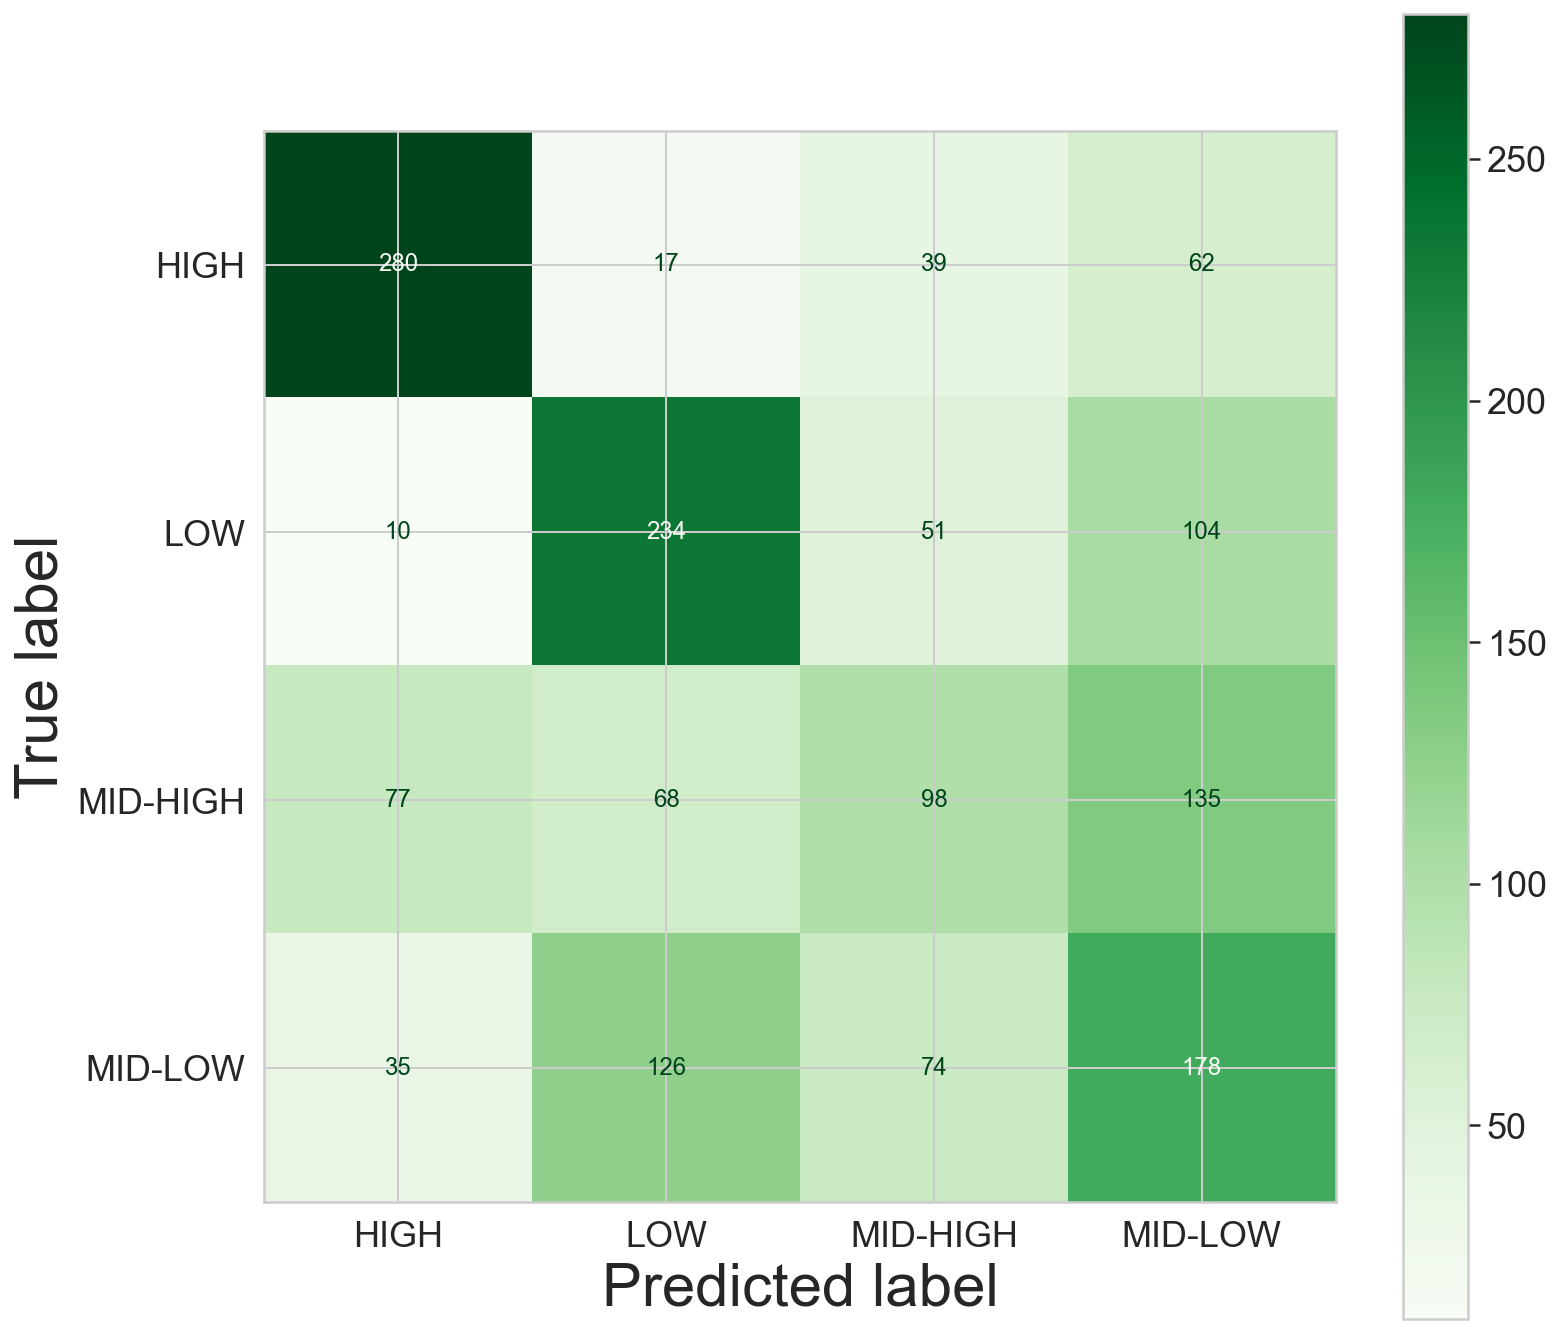

In [682]:
fig,ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(lr_tuned, X2_train, y2_train, cmap='Greens', labels=lr_tuned.classes_, values_format='.0f',ax=ax)
plt.show();

The above confusin matrix is useful because it visualises how exactly the model is performing. In the above section we calculated the accuracy score for this model: {{tuned_lr_cv_score}}

The matrix shows that the model is predicts HIGH salaries with the most frequency. It also shows us that of these predictions, while 280 of them are correct 122 are incorrect.

Below is the classification report for this model:

In [685]:
predictions = lr_tuned.predict(X2_train)
print(classification_report(y2_train, predictions, digits=4))

              precision    recall  f1-score   support

        HIGH     0.6965    0.7035    0.7000       398
         LOW     0.5258    0.5865    0.5545       399
    MID-HIGH     0.3740    0.2593    0.3062       378
     MID-LOW     0.3716    0.4310    0.3991       413

    accuracy                         0.4975      1588
   macro avg     0.4920    0.4951    0.4900      1588
weighted avg     0.4924    0.4975    0.4915      1588



This report shows the precision, recall and f1-score for each class.

For evaluating this model, I will look at the precision and the recall.

#### Precision

For all the positive predictions made by the model, how many of those predictions are accurate:

$Precision = \frac{true-positive}{true-positive + false-positive}$

True positives are where the model predicts true and the actual class is true.
False positives are where the model predicts true but the actual class is false.

The precision metrics for each class should be interpreted as follows:

HIGH -- Of all the cases where HIGH was predicted, 69.65% were correct.

LOW -- Of all the cases where LOW was predicted, 52.58% were correct.

MID-HIGH -- Of all the cases where MID-HIGH was predicted, 37.40% were correct.

MID-LOW -- Of all the cases where MID-LOW was predicted, 37.16% were correct.

Since the boss has said that he would prefer we incorrectly predict that a client will get a low salary job than a high salary job, we need to tune the model to maximise precision for the HIGH class.

You want high precision when the costs of incorrectly classifying something as a particular class are high. In this instance a high precision for predicting HIGH is desirable because if you predict HIGH and the salary is actually LOW, then this will disappoint the client and may result in losing their custom, whereas if you predict LOW and the salary is actually HIGH, then the client will be pleasantly surprised.

#### Recall

Of all the actual positive cases, how many does the model correctly classify as positive:

$Recall = \frac{true-positive}{true-positive + false-negative}$

True positives are where the model predicts true and the actual class is true.
False negatives are where the model predicts false but the actual class is true.

The recall metrics for each class should be interpreted as follows:

HIGH -- Of all the actual cases of HIGH salaries, 70.35% were correctly classified.

LOW -- Of all the actual cases of LOW salaries, 58.65% were correctly classified.

MID-HIGH -- Of all the actual cases of MID-HIGH salaries, 25.93% were correctly classified.

MID-LOW -- Of all the actual cases of MID-LOW salaries, 43.10% were correctly classified.

High recall is especially important when the costs of misclassifying an instance of a class is high. For example, in fraud detection, it is important to have a high recall, where you correctly classify all fraudulent transactions. Otherwise you may allow fraudulent transactions to go through and clients may lose a lot of money. There is a trade off here because if you misclassify too many transactions as fraudulent which are not, you may lose their custom too.

### ROC-AUC Score

In [695]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette('husl',3))

In [851]:
probabilities = pd.DataFrame(lr_tuned.predict_proba(X2_train),columns=lr_tuned.classes_)
probabilities.head()

HIGH       LOW  MID-HIGH   MID-LOW
0  0.647318  0.111638  0.142670  0.098374
1  0.620119  0.060749  0.168726  0.150406
2  0.068458  0.293280  0.319295  0.318967
3  0.257397  0.241110  0.221172  0.280321
4  0.051555  0.226729  0.221756  0.499960

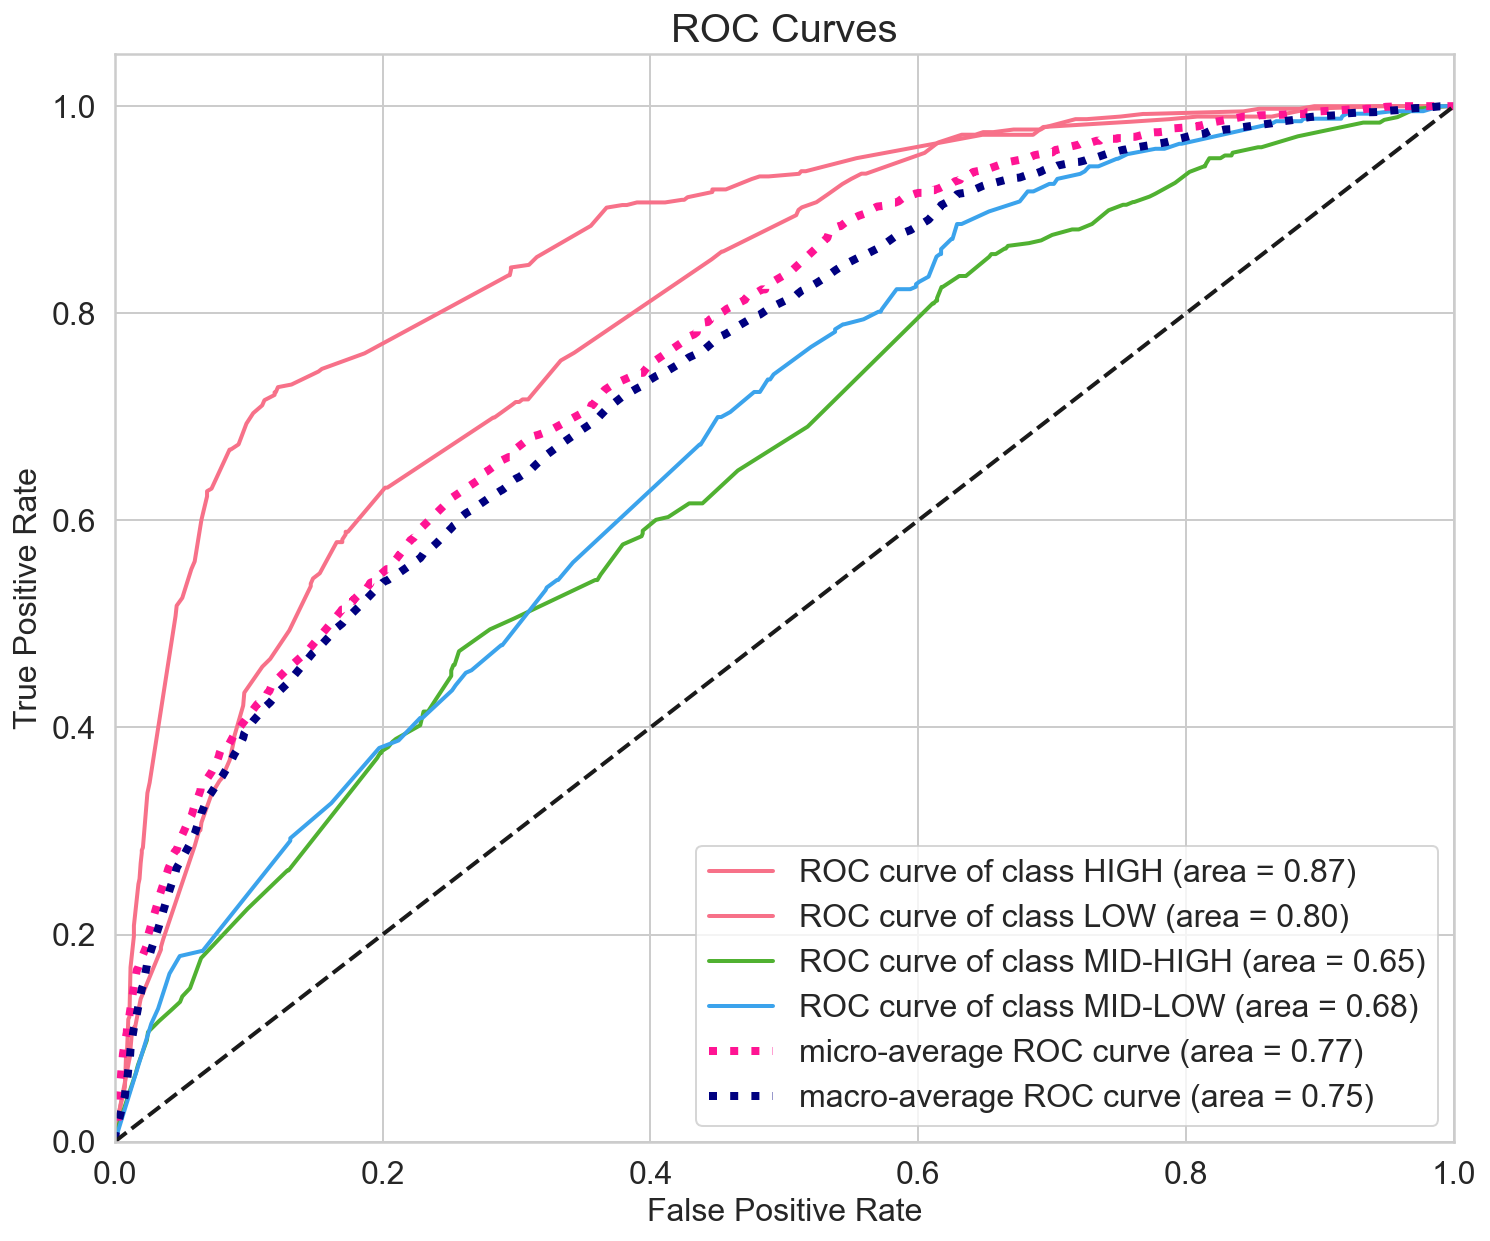

In [728]:
skplt.metrics.plot_roc(y2_train, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(12,10), cmap=cmap)
plt.show()

In [699]:
roc_auc_score(y2_train, probabilities,multi_class='ovr')

0.7475641055657539

The ROC-AUC curve tells us how much the false positive rate increases, as you increase your true positive rate.

The ROC-AUC score tells us the area under the curve, and is a measure of the separability of each one class from the rest. The higher this score is, then the greater the dstinction is and the less cross over there is between classes.

This intuitively makes sense. The true positive rate measures for all insatnces of a class, how many of those instances doe the model classify correctly. The false positive rate measures for all instances of a not a class, how many of those instances does the model categorise as belonging to a class.

If the model predicts HIGH for every value, it will correctly hit all the rows where the class is HIGH, so the true positive rate will be 1 -- but it will misclassify all the rows where the class is not HIGH so the false positive rate will be 1 too. This curve displays that trade off.

In this instance, our macro-average ROC-AUC score (average taken by averaging the other ROC-AUC scores) is 0.7475. For a model that randomly guesses predictions, the AUC is 0.5, therefore a score >0.5 is better than randomly guessing.

### Precision-Recall curve

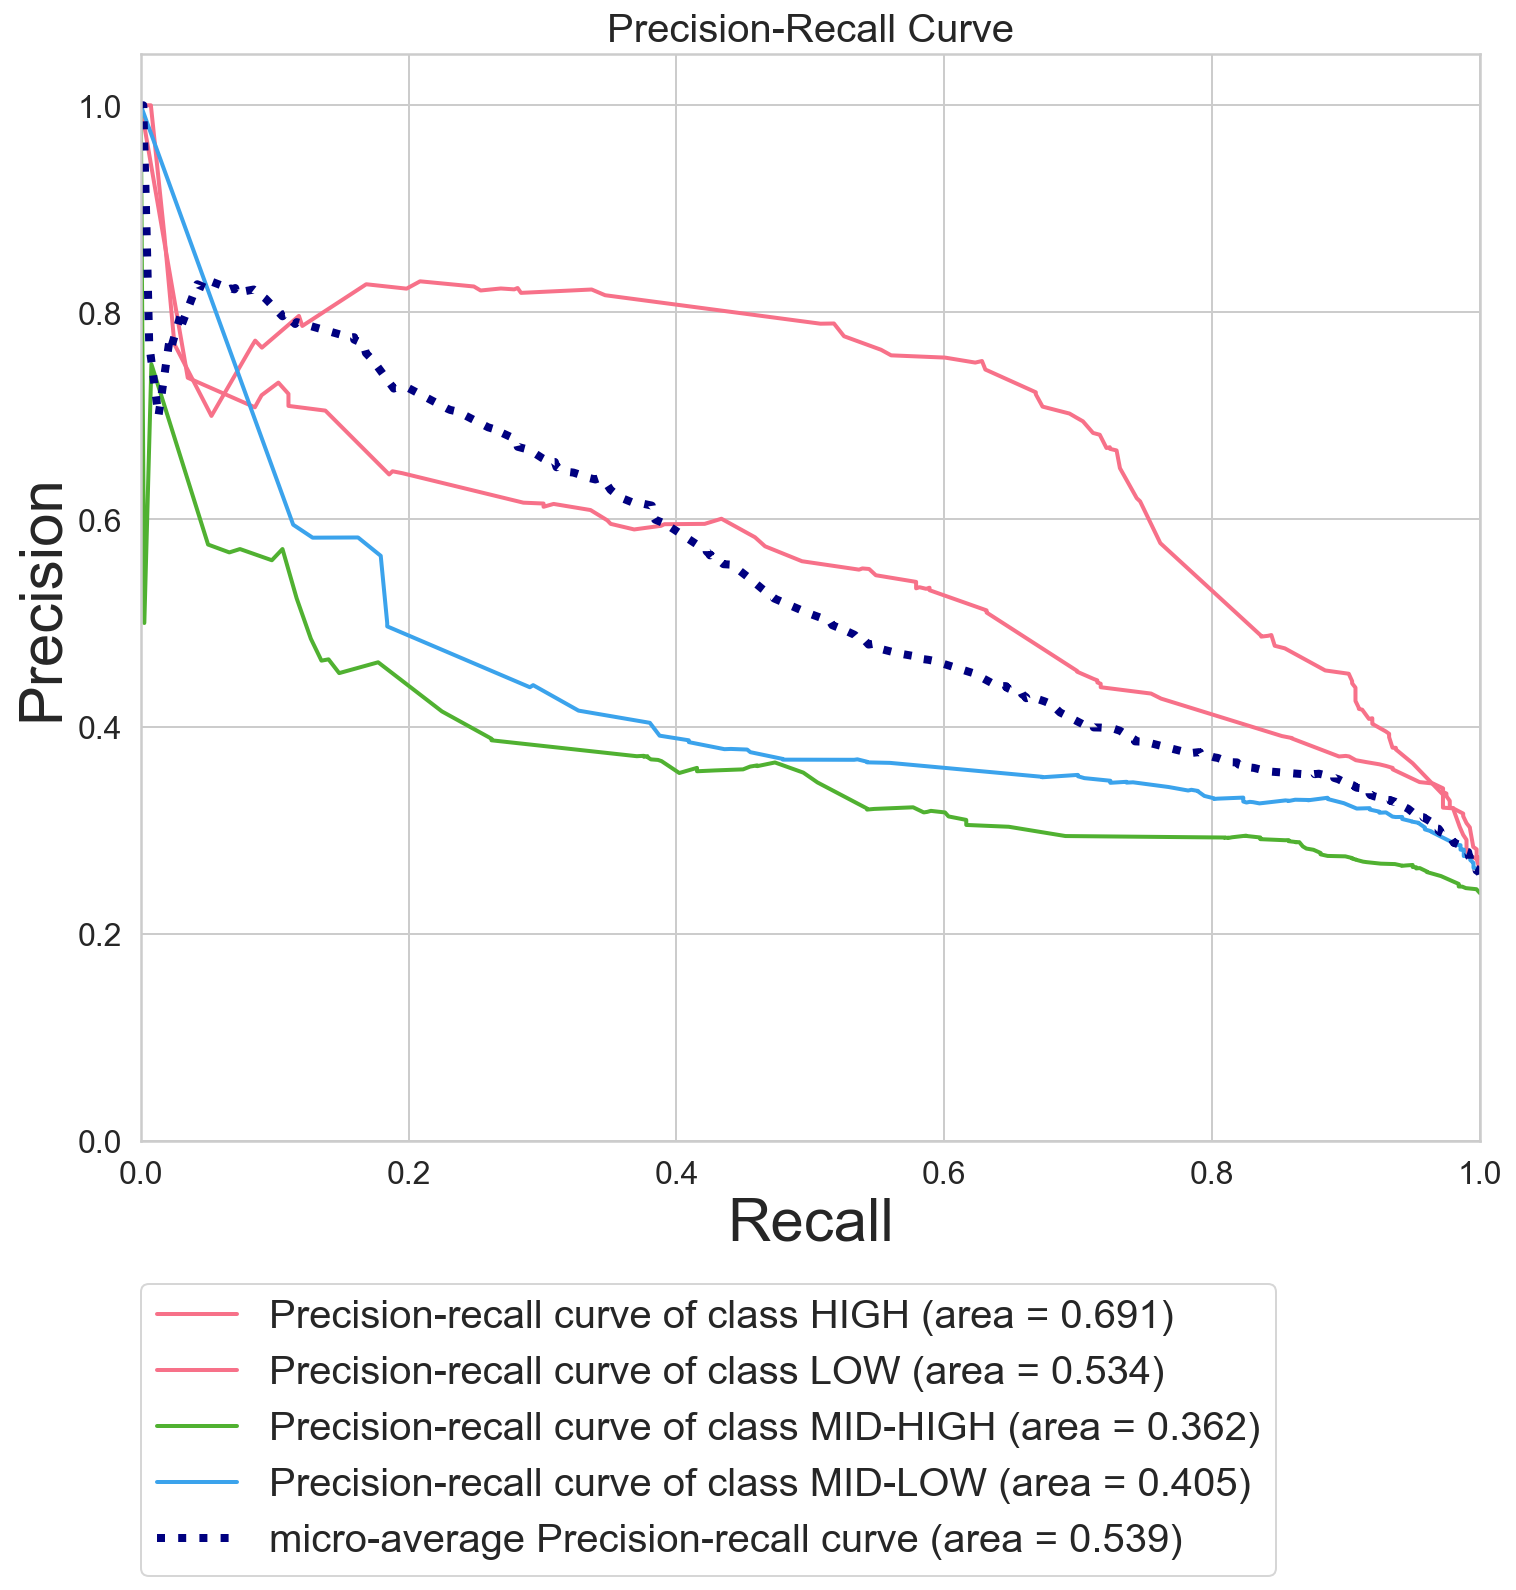

In [741]:
fig, ax = plt.subplots(figsize=(12,10))
skplt.metrics.plot_precision_recall(y2_train, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[0,-0.4], prop = {'size':20})
plt.show()

The precision-recall curve visualizes the trade off between precision and recall at different probability thresholds. 

In a perfect model, as the recall increases, the precision remains at 1. For this model, however, as the recall increases the precision falls. This means that as you increase the rate at which the model correctly classifies each actual instance of 'HIGH' as 'HIGH' for example, then you will also increase the rate of incorrectly classifying instances of 'NOT HIGH' as 'HIGH'.

What we can use this curve to identify an optimal threshold point. To me the optimum threshold for predicting HIGH is when precision = 0.8, recall = 0.4.


### Tune threshold to maximise HIGH precision

This classifier model works by predicting the probability that a row belongs to each salary_band (HIGH,LOW,MID-HIGH,MID-LOW) and classifying it based on which class is most likely. 

We can tune the threshold so that the model only assigns a  class to a row where the probability of it belonging to that class exceeds are given threshold. This means we can make the model only predict a class when it is sure of an insatnce of a given class, thereby increasing the precision of the model. However, this will reduce the recall. This is explained further below.

In [833]:
def predict_at_threshold(X, threshold=0.5):
    if X['HIGH'] > threshold:
        return 'HIGH'
    else:
        return X.loc['LOW':].idxmax()

In [843]:
threshold_predict = probabilities.apply(predict_at_threshold,threshold=0.6,axis=1)

In [844]:
pd.DataFrame(confusion_matrix(y2_train, threshold_predict, labels = ['HIGH','LOW','MID-HIGH','MID-LOW']), columns=['HIGH','LOW','MID-HIGH','MID-LOW'],index=['HIGH','LOW','MID-HIGH','MID-LOW'])

HIGH  LOW  MID-HIGH  MID-LOW
HIGH       134   27       154       83
LOW          2  237        56      104
MID-HIGH    19   72       142      145
MID-LOW      8  129        92      184

In [845]:
print(classification_report(y2_train,  threshold_predict, digits = 4, zero_division = 1))

              precision    recall  f1-score   support

        HIGH     0.8221    0.3367    0.4777       398
         LOW     0.5097    0.5940    0.5486       399
    MID-HIGH     0.3198    0.3757    0.3455       378
     MID-LOW     0.3566    0.4455    0.3961       413

    accuracy                         0.4389      1588
   macro avg     0.5020    0.4380    0.4420      1588
weighted avg     0.5030    0.4389    0.4428      1588



After adjusting the threshold for the model, the precision for predicting HIGH has increased from 0.6965 to 0.7891.

This means that before, 69.65% of instances when the model predicted HIGH were correct. Now 82.21% of instances when the model predicts HIGH are correct. 

There has, however, been a drop off in recall as a result:

Before_tuning: 0.7035

After_tuning: 0.3367

This means that before tuning, of all actual instances where salary was HIGH, the model correctly classified 70.35% of them. After tuning though, the model only correctly classifies 33.67% of all actual instances of HIGH.

Equally, the accuracy score for the model has dropped off by approximately 0.04. This model still performs much better than the baseline accuracy.

There are several important caveats that should be made clear before pursuing this threshold:
1. The probability threshold has only been applied to the HIGH salary band. Where the probability for HIGH is highest but does not meet the threshold, the next most likely class has been selected. I would confirm with business teams that this is the preferred treatment.
2. The recall is 0.3367 - this is not a good score. Can I confirm with the business team that they are happy with this recall to preserve precision?


## Decision Tree Classifier

### Confusion Matrix and Classification Report

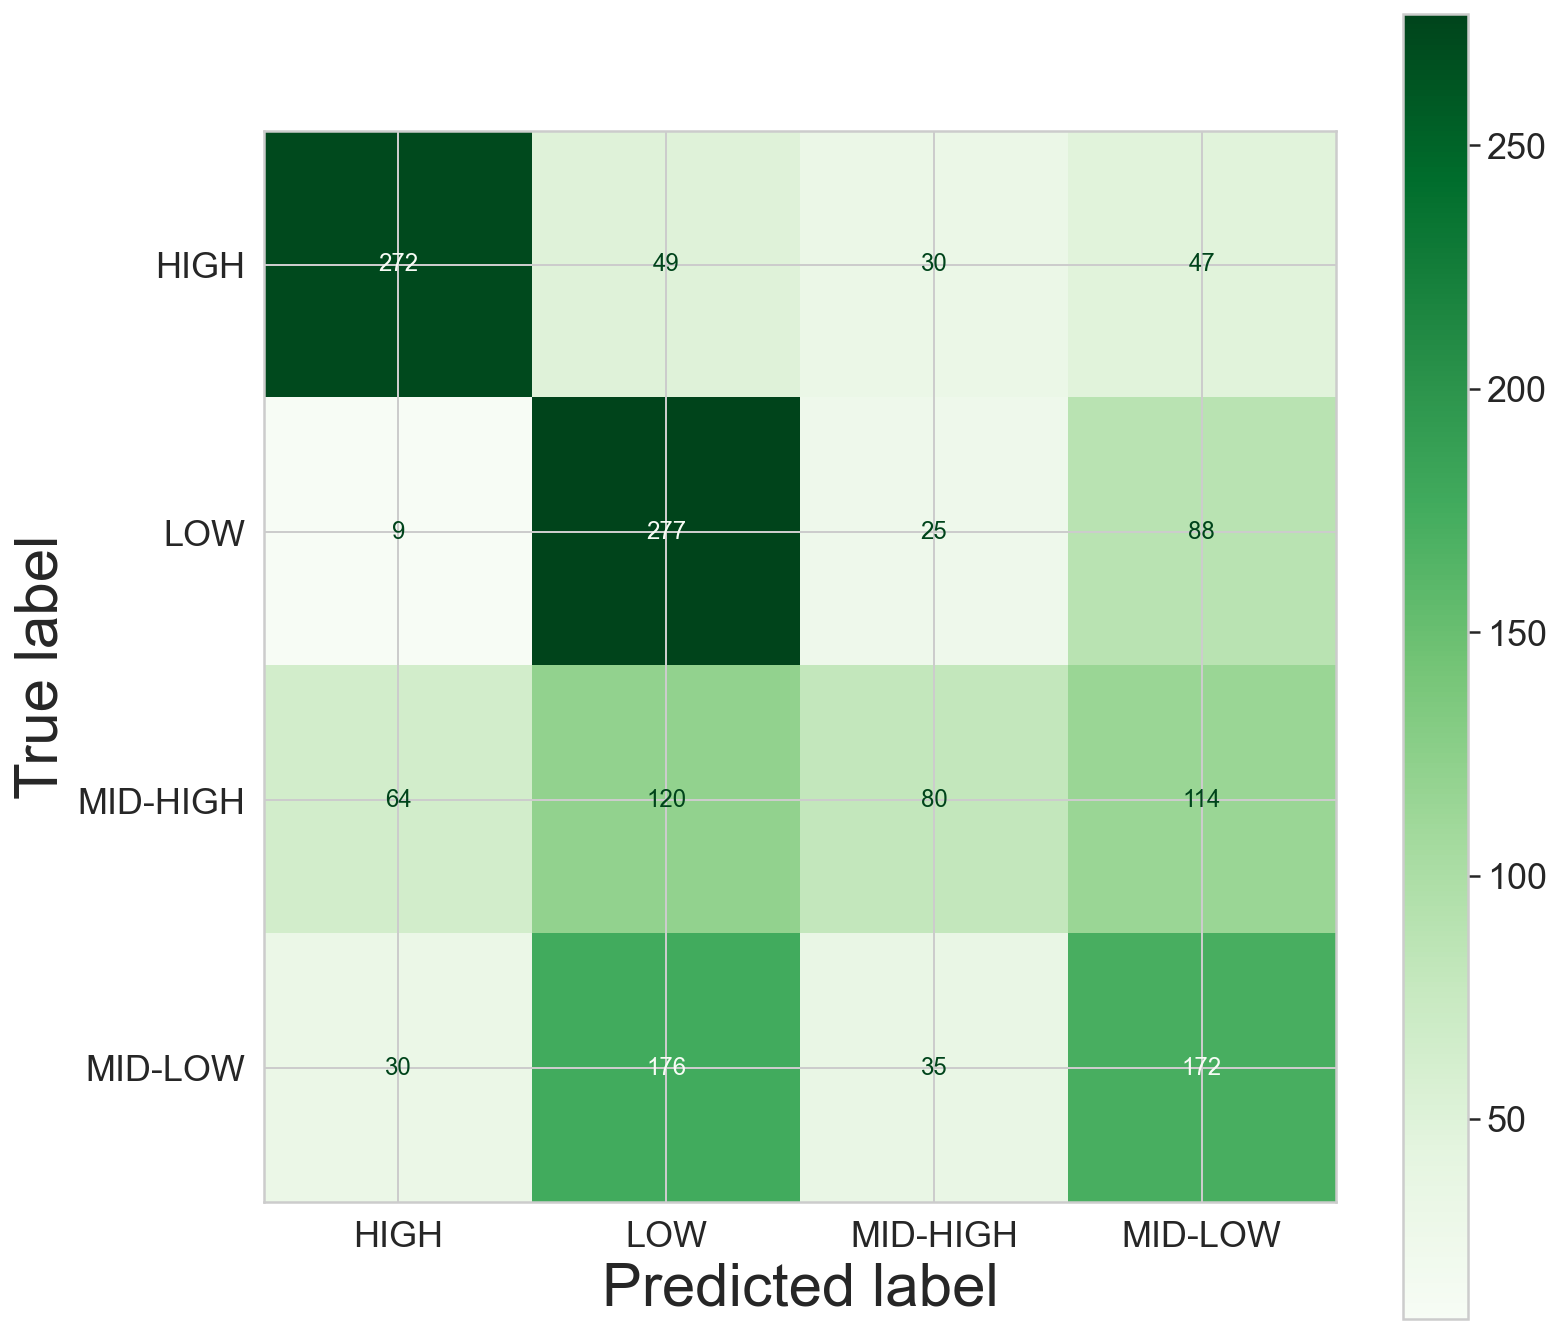

In [846]:
fig,ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(dtc_tuned, X2_train, y2_train, cmap='Greens', labels=dtc_tuned.classes_, values_format='.0f',ax=ax)
plt.show();

We have already calculated the cross_validated score for this model: {{dtc_tuned_cv_score}}

Lets look at the classification report for this model:

In [850]:
print(classification_report(y2_train, dtc_tuned.predict(X2_train), digits = 4))

              precision    recall  f1-score   support

        HIGH     0.7253    0.6834    0.7038       398
         LOW     0.4453    0.6942    0.5426       399
    MID-HIGH     0.4706    0.2116    0.2920       378
     MID-LOW     0.4086    0.4165    0.4125       413

    accuracy                         0.5044      1588
   macro avg     0.5125    0.5014    0.4877      1588
weighted avg     0.5120    0.5044    0.4895      1588



This report shows the precision of the model for classifiying HIGH salaries in 0.7253 and the recall is 0.6834.

This means that for all predictions of HIGH the model gets 72.53% of them correct and for all actual instance of a HIGH salary, the model correctly classifies them 68.34% of the time.

Equally, the accuracy score is 0.5044 - this means that of all the predictions the model makes, it is correct 50.44% of the time. This is far better than the baseline accuracy of {{round(baseline_accuracy * 100,2)}}.

### ROC-AUC Score

In [852]:
probabilities_dtc = pd.DataFrame(dtc_tuned.predict_proba(X2_train),columns=dtc_tuned.classes_)
probabilities_dtc.head()

HIGH       LOW  MID-HIGH   MID-LOW
0  0.800000  0.200000  0.000000  0.000000
1  0.840000  0.000000  0.080000  0.080000
2  0.081871  0.257310  0.321637  0.339181
3  0.095137  0.397463  0.226216  0.281184
4  0.025316  0.177215  0.202532  0.594937

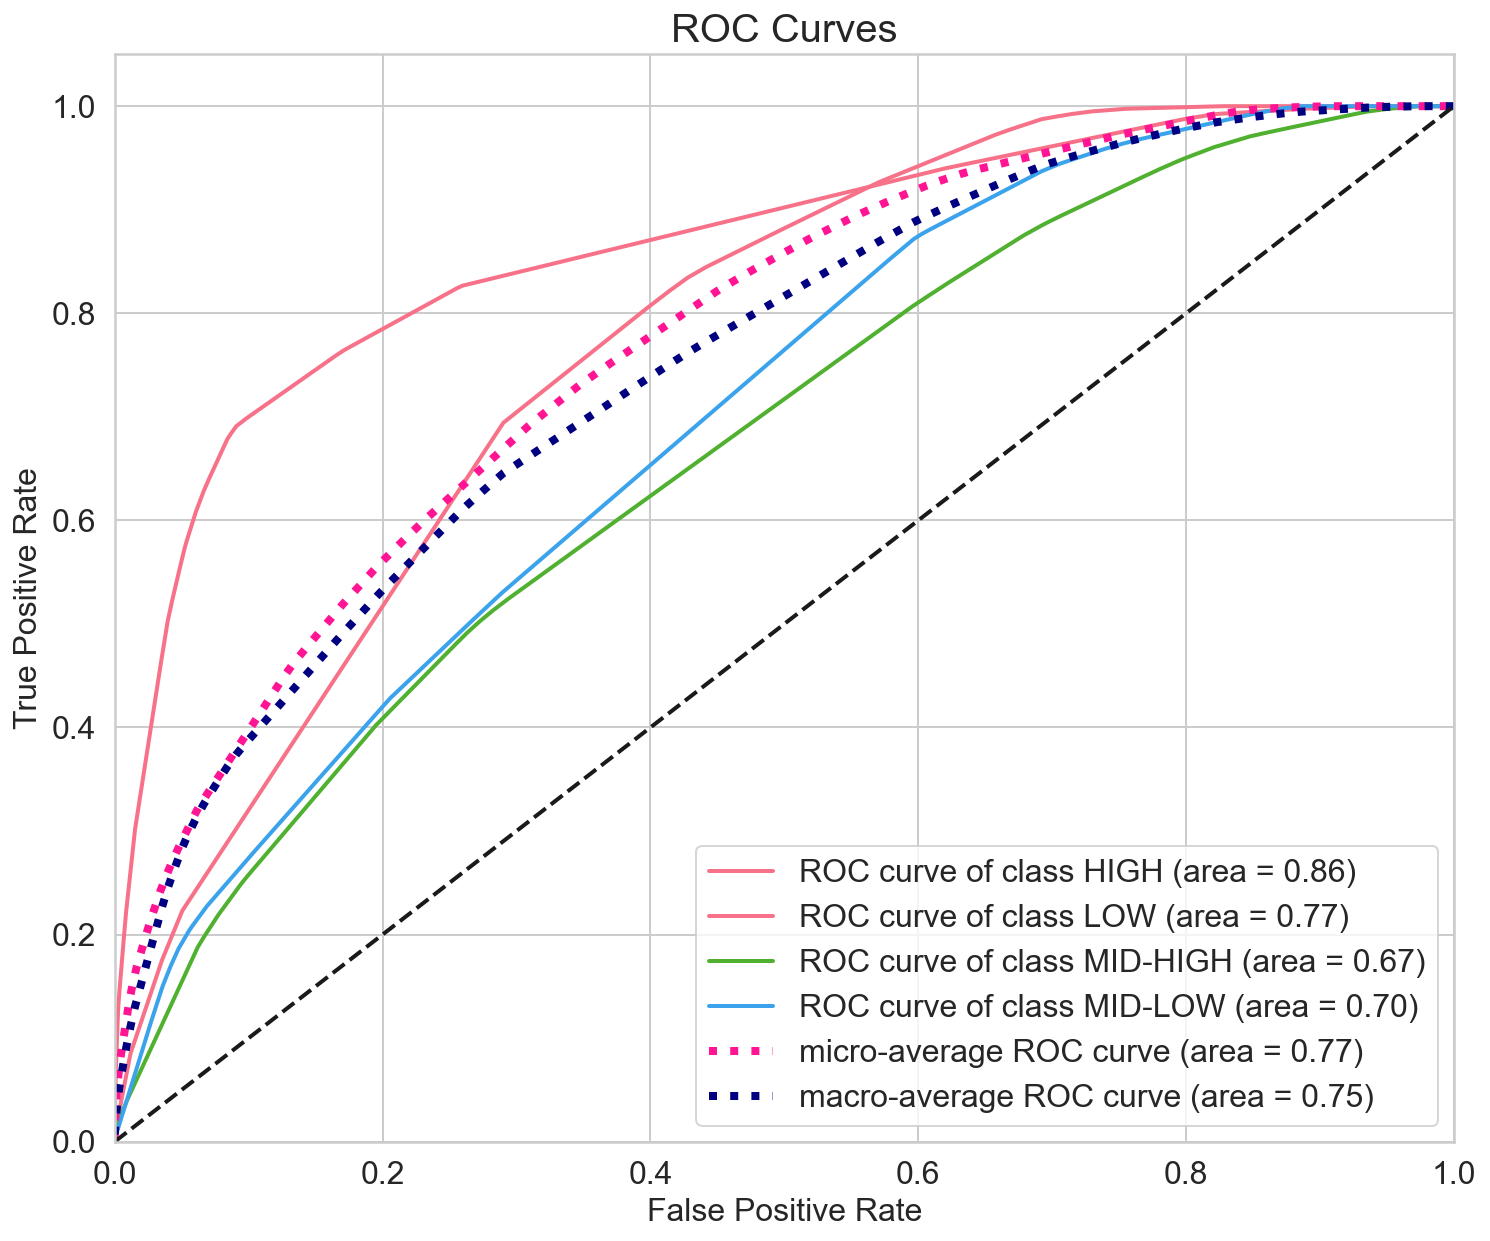

In [854]:
skplt.metrics.plot_roc(y2_train, probabilities_dtc, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(12,10), cmap=cmap)
plt.show()

These ROC curves show that for each class our model is more effective than random guessing. 

This model performs best at classifying salaries which are HIGH. This is good given the specifications from the boss. It is worst at classifying MID-HIGH salaries, although the classifications are still mbetter than guessing.

### Precision-Recall

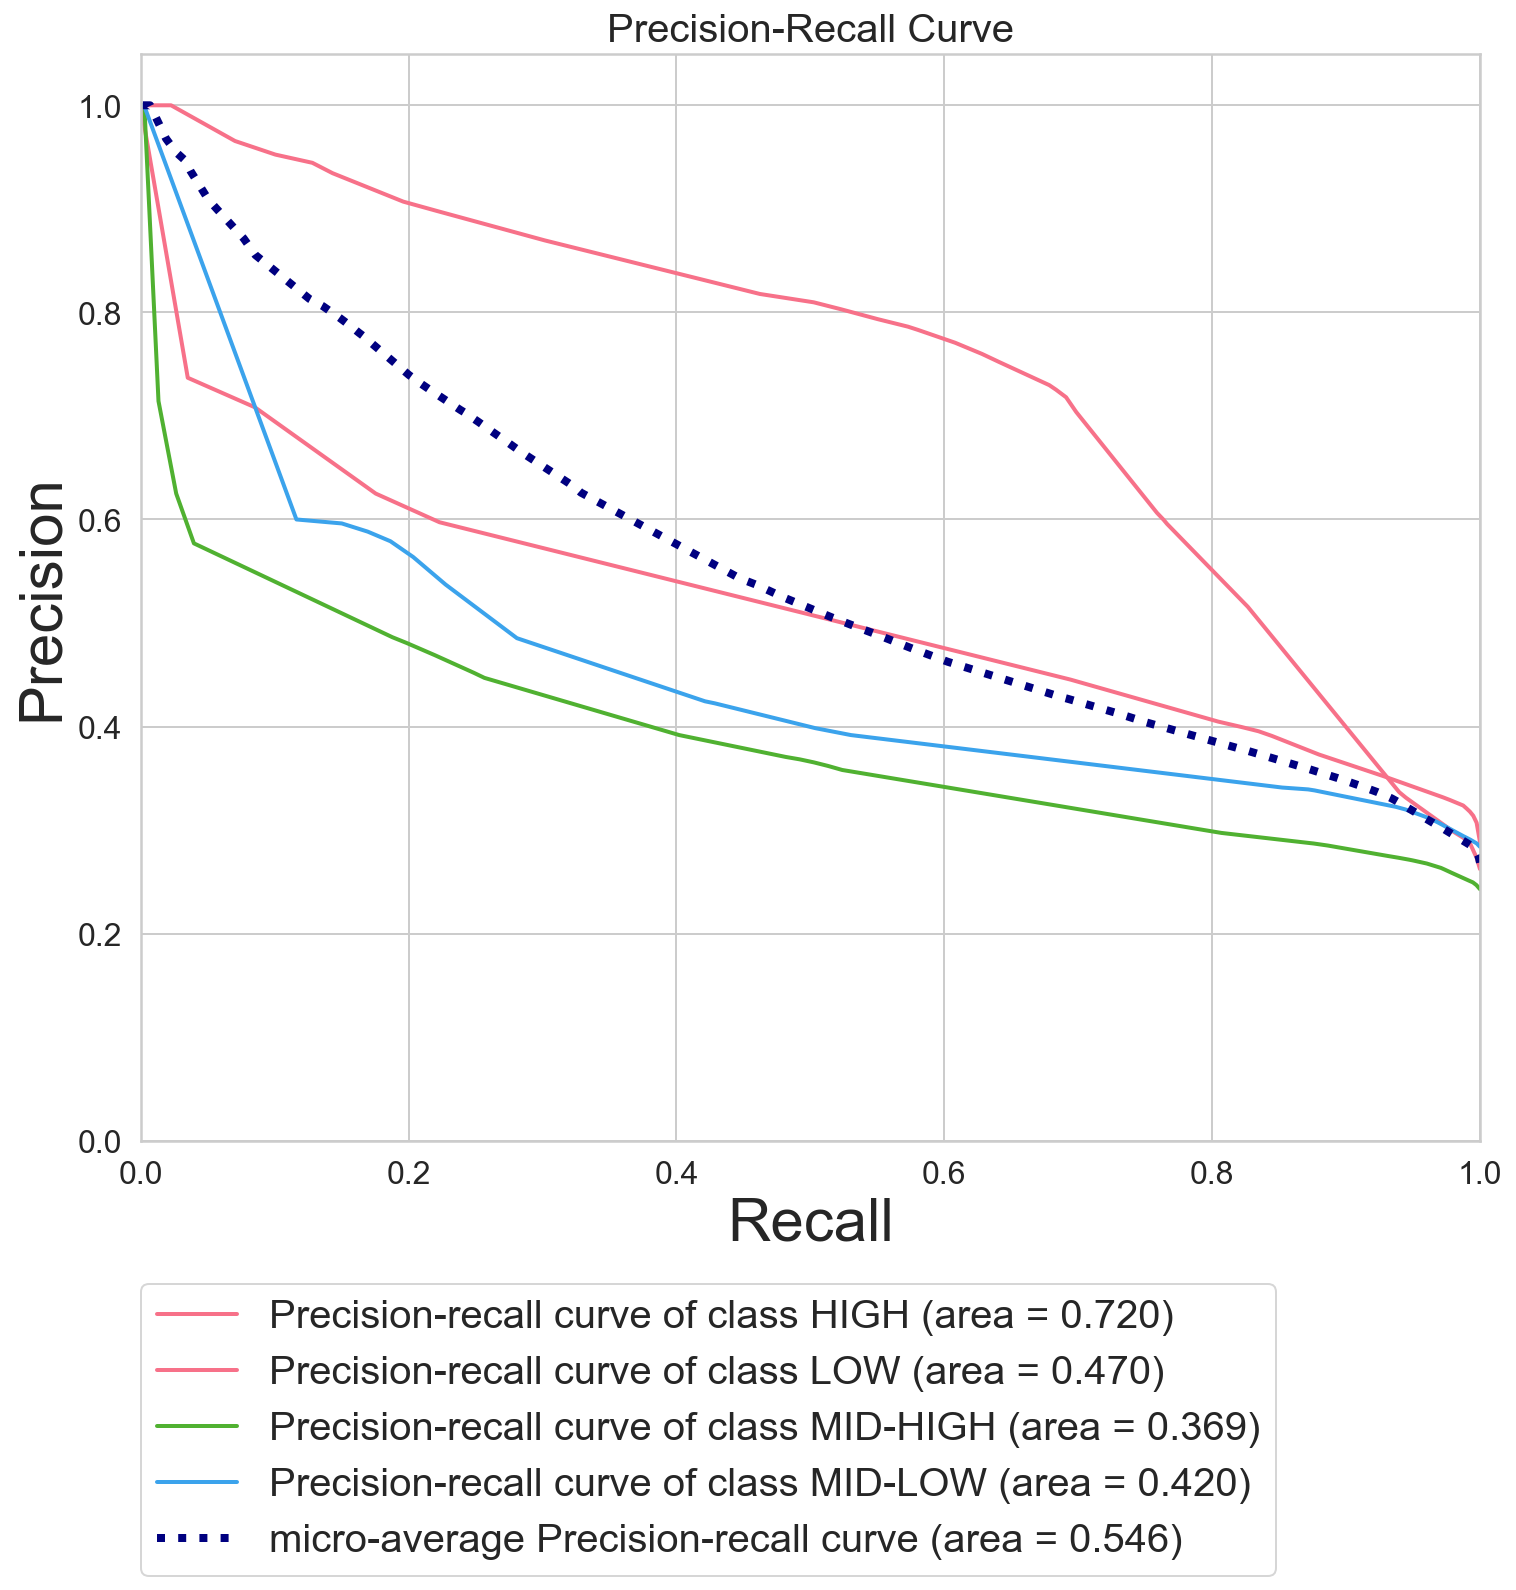

In [855]:
fig, ax = plt.subplots(figsize=(12,10))
skplt.metrics.plot_precision_recall(y2_train, probabilities_dtc, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[0,-0.4], prop = {'size':20})
plt.show()

The above graph shows that as you decrease the probability threshold and the recall increases, the drop in precision for LOW, MID-LOW, and MID-HIGH are quite sharp, but for HIGH the drop remains steady until a recall of approximately 0.7, at which point the precision falls more sharply from 0.7 itself.

We can use this curve to optimise for the best probability threshold by identifying the point on the curve which suite the business case best. I would discuss this with the business teams to identify the optimal prediction-recall balance.

## Compare models

Having generated precision-recall and ROC curves for both models, we can compare models.

The LogisticRegression model is marginally better at predicting HIGH and LOW salaries than the DecisionTreeClassifier, but the DecisionTreeClassifier is better at classifying MID-HIGH and MID-LOW salaries. The margin of difference here is small though, both models perform similarly, and both perform better than guessing.

The general shape of the precision-recall curves are similar too, though the LogisticRegression curve sees a sharp drop initially in the precision-recall curve for HIGH salaries, but this recovers and follows the same general trend as the HIGH curve for the DecisionTreeClassifier.

If I had to pick one model to use, I would use the DecisionTreeClassifier as this model is far more interpretable.

-----

## Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

## Executive Summary

### Context
This is an assignment that was given to me while studying at General Assembly. The project was split into the following sub-tasks:
Build a web scrape and scrape indeed.com
Information scraped:
Title
Location
Company
Salary
Clean and normalise scraped data
Fit two different classifier models on cleaned data using only the location as a predictor
Create more variables from scraped data to act as predictors
Re-fit two different classifier models on data using new predictors
Tune re-fitted models to optimise parameters
Evaluate re-fitted models

### Web Scrape
Indeed is known for being difficult to scrape, and it is important to rotate through IP addresses to mask your identity otherwise they will give you a captcha. A captcha is a way of preventing bots from scraping their site because it presents the algorithm with a task that is challenging for computers to solve but solvable by humans (although they’re getting harder!). While it is possible to write a programme to solve the Captcha, it’s easier to just avoid the captcha altogether.

To avoid the captcha, I encrypted my connection using ExpressVPN, a paid VPN service provider. I also downloaded tor using the terminal command `brew install tor` and then ran it in my terminal during the scrape. This means my IP address is routed through several different tor nodes and re-assigned at each one, masking my computer’s IP address from Indeed. (Got to avoid that ban!) By connecting to the VPN first, it masks my traffic and identity both from my ISP and potentially malicious tor nodes, adding further security and privacy. Finally, I also updated the user-agent field I sent to indeed to that which my computer usually sends when I am accessing a website with my browser. If I don’t do this Indeed can see that it is a script running and can throw up a captcha.

I scraped through 21 cities: 16 in the UK, 5 in the US and 4 in the EU; and 3 job titles per city: data scientist, data analyst and data engineer. I reset my IP address for every city and if a captcha was thrown. In the case of captcha recurring after successive IP resets, the web scrape broke so I could manually investigate (this never happened). Finally, after scraping through a page, I delayed the scrape from accessing the next page for a random amount of time up to 20 seconds.

Finally, I deduplicated rows and dropped all rows without salary data, leaving a total of 1986 usable results for modelling. I saved this to a csv: `jobs.csv`.

### Data Cleaning
I loaded the data from jobs.csv and did some clean up on the job_title column. This mostly involved using regex to pull job_titles from sentences detailing job descriptions, as well as some minor tweaks to formatting.

I also cleaned the location column to group the jobs into the nearest city of the cities I scraped. 

For the salary column, I dropped all rows where the salary was not quoted in years. Then I analysed each string, and where a range was presented I converted this to the mean between the two values. Otherwise, I just converted the string to a number. Since there were multiple currencies pulled: EUR, GBP and USD, I converted all salaries to USD using the `forex_python.converter` library.

Finally, because we were creating a classifier model I analysed the salary target variable to identify which classes to define as target variables. I observed that the range of salaries was very high, so instead of two classes, I created four predictor classes:
|Category|Salary Band|Percentile|
|----|----|----|
|LOW|<= 48937.11|25th percentile|
|MID-LOW|48937.11 - 63046.50|50th percentile|
|MID-HIGH|63046.50 - 82400.00|75th percentile|
|HIGH|82400.00 < salary|100th percentile|

I classified each row in the `salary_band` column.

I also calculated the baseline accuracy for the dataset. The baseline accuracy of the model is what accuracy we can expect if we always predict the largest group. We can use the baseline accuracy to identify if we are performing better than just guessing the largest category each time. The baseline accuracy for this dataset is 26.03% if you always predict the `MID-LOW` category.

### Location Only
When predicting only the location, I used two models: Logistic Regression and Decision Tree Classifier.

#### Logistic Regression
After fitting this model, we received a mean cross-validation score of 0.4446. What this means is that of all the predictions the model made, it was right 44.46% of the time. This may not sound spectacular, but if you guess the largest group each time, you can only expect to be right 26.03% of the time. Therefore being correct 44.46% of the time is a large improvement on the baseline accuracy.

The top 5 most important coefficients for predicting each category are:

|HIGH|MID-HIGH|MID-LOW|LOW|
|-----|-----|-----|-----|
|New York|New Orleans|Paris|Liverpool|
|Chicago|New York|Swansea|Leeds|
|London|Chicago|Liverpool|Glasgow|
|Los Angeles|Glasgow|Glasgow|Belfast|
|Austin|Amsterdam|Leeds|Swansea|

#### Decision Tree Classifier
For this model, we had a mean cross-validation score of 0.4484, translating to a model that accurately predicts the correct class 44.84% of the time. Again, against the baseline accuracy, this is a vast improvement and it is even a small improvement on the Logistic Regression model above.

The top 5 most important features for this model are:
New York
London
Austin
Chicago
Los Angeles

I have explained above by what criteria these features are ranked.

### Feature Engineering
After fitting the above models for location only, we were tasked with identifying other variables for predicting salary bands.

I created four predictors:
Seniority_senior
Seniority_junior
Seniority_mid_level
Is_engineer
To create my seniority predictors, I compiled a dictionary with keys: senior, junior; which mapped to lists containing words that indicate if a job is senior or junior. To create my is_engineer predictor, I checked if the title had the word engineer in it, if it did the cell was 1, if not the cell became 0.

### Multi-featured models

#### Logistic Regression
I fitted a new Logistic Regression model using the location and the new predictors as predictor variables, and salary_band the target once again. The mean cross-validation score for this model was 0.4943, meaning it predicted correctly 49.43% of the time. This was an improvement of approximately 5% on the first Logistic regression model.

The top 5 predictors for this model were:

|HIGH|MID-HIGH|MID-LOW|LOW|
|-----|-----|-----|-----|
|seniority_senior|location_amsterdam|location_swansea|location_liverpool|
|location_new_york|seniority_senior|location_paris|location_leeds|
|is_engineer|location_new_york|location_glasgow|location_kent|
|location_london|location_chicago|location_new_orleans|location_swansea|
|location_chicago|location_new_orleans|location_liverpool|location_glasgow|

After this, I used a Grid Search (a python class) to optimise my Logistic Regression hyperparameters. After tuning, the best model had a mean cross-validation score of 0.4836. This is lower than the model before tuning, but this is because it applies a penalty function to ensure the model doesn’t overfit the training data. (Overfitting is when the model cannot generalise to unseen data). It also has the advantage of zeroing out redundant columns, making it possible to prune the features in the model and make it run faster. This is important when running models at scale.

#### Decision Tree Classifier
For the Decision Tree Classifier, we got a mean cross-validation score of 0.4804. Again an improvement on the location only classifier, and it has comparable predictive ability as the Logistic Regression model above.

I tuned the model from the start, I did not fit a model without running it through Grid Search first.

The top 5 most important features according to this model are:
Seniority_senior
Location_new_york
Is_engineer
Location_chicago
Location_paris

### Model Evaluation

#### Logistic Regression
The goal of this model is to predict the salary bands of a job given the location and job title. It is important, however, that the model does not predict the salary will be HIGH when it is not. If it does, this will undermine client trust, whereas if the model predicts LOW and the salary is HIGH, the client will be happy. The main metric that measures this is called precision. This can be defined as, for all the times the model predicts a certain class, how many of those predictions are correct. 

The model initially had a `HIGH` precision of 0.6965, meaning that 69.65% of all cases where the model predicted `HIGH` were correct. 

It is possible to tune this and change the threshold of certainty at which the model will predict whether the class is HIGH or not. I changed the model so that it would predict if the class was HIGH if the probability that it was was greater than 0.6. This raised the precision to 0.8221 - 82.21% of all predictions of HIGH are correct. 

There is a trade-off here - another metric called recall measures of all the instances of a job actually having a HIGH salary, how many of those does the model correctly classify as having a HIGH salary. For the model without a threshold, the recall is 0.7035. This means that of all actual instances of a HIGH salary, the model correctly classifies 70.35% of them. After adjusting the threshold, though, the recall becomes 0.3367 - the model correctly classifies just 33.67% of all actual instances of HIGH salaries as HIGH. It is important to find the right balance between recall and precision to maximise consumer confidence in this model.

### Decision Tree Classifier

This model I did not tune with a threshold, but I will still report on the precision and recall scores.

The precision for predicting HIGH for this model is 0.7253 - 72.53% of all predictions of HIGH are correct predictions. The recall for predicting HIGH for this model is 0.6834 - 68.34% of all instances of HIGH are correctly classified as HIGH.

If I had to pick one model, I would use the Decision Tree Classifier, as it is far more interpretable than a Logistic Regression. Especially for multiclass prediction.
